# A hierarchcial linear regression to fit CRISPR-Cas9 screen results

This notebook is intended to experiment with various hierarchical model architectures on a sub-sample of the real DepMap data.

## Set-up

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Optional, Tuple

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
import string_functions as stringr
from common_data_processing import get_indices, make_cat, zscale_cna_by_group
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 824
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Data preparation

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

data = data.sort_values(["hugo_symbol", "sgrna", "depmap_id"]).reset_index(drop=True)
for col in ("hugo_symbol", "depmap_id", "sgrna", "lineage", "chromosome"):
    data = make_cat(data, col, ordered=True, sort_cats=False)

data = zscale_cna_by_group(data, cn_max=10)

data.head(n=7)

sgrna                    replicate_id       lfc  pdna_batch  \
0  CCACCCACAGACGCTCAGCA    ls513-311cas9_repa_p6_batch2  0.029491           2   
1  CCACCCACAGACGCTCAGCA    ls513-311cas9_repb_p6_batch2  0.426017           2   
2  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep a p5_batch3  0.008626           3   
3  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep b p5_batch3  0.280821           3   
4  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep c p5_batch3  0.239815           3   
5  CCACCCACAGACGCTCAGCA  hcc827-311cas9 rep a p6_batch3 -0.170583           3   
6  CCACCCACAGACGCTCAGCA  hcc827-311cas9 rep b p6_batch3 -0.320019           3   

   passes_qc   depmap_id primary_or_metastasis     lineage  \
0       True  ACH-000007               Primary  colorectal   
1       True  ACH-000007               Primary  colorectal   
2       True  ACH-000009               Primary  colorectal   
3       True  ACH-000009               Primary  colorectal   
4       True  ACH-000009               Primary  colorectal   
5       True  ACH-000012               Primary        lung   
6       True  ACH-000012               Primary        lung   

             lineage_subtype kras_mutation  ...   gene_cn  n_muts  \
0  colorectal_adenocarcinoma          G12D  ...  2.632957       0   
1  colorectal_adenocarcinoma          G12D  ...  2.632957       0   
2  colorectal_adenocarcinoma            WT  ...  1.594524       0   
3  colorectal_adenocarcinoma            WT  ...  1.594524       0   
4  colorectal_adenocarcinoma            WT  ...  1.594524       0   
5                      NSCLC            WT  ...  1.741667       0   
6                      NSCLC            WT  ...  1.741667       0   

  any_deleterious variant_classification  is_deleterious  is_tcga_hotspot  \
0           False                    NaN             NaN              NaN   
1           False                    NaN             NaN              NaN   
2           False                    NaN             NaN              NaN   
3           False                    NaN             NaN              NaN   
4           False                    NaN             NaN              NaN   
5           False                    NaN             NaN              NaN   
6           False                    NaN             NaN              NaN   

   is_cosmic_hotspot  mutated_at_guide_location  rna_expr  gene_cn_z  
0                NaN                      False  1.480265   1.632215  
1                NaN                      False  1.480265   1.632215  
2                NaN                      False  0.695994  -0.365193  
3                NaN                      False  0.695994  -0.365193  
4                NaN                      False  0.695994  -0.365193  
5                NaN                      False  1.042644  -0.082165  
6                NaN                      False  1.042644  -0.082165  

[7 rows x 28 columns]

In [3]:
data.describe()

lfc    pdna_batch  n_alignments     chrom_pos  segment_mean  \
count  60049.000000  60049.000000  60049.000000  6.004900e+04  5.984300e+04   
mean      -0.110098      2.861063      1.029126  8.199159e+07  1.052517e+00   
std        0.562585      0.355663      0.168162  6.014320e+07  8.296245e-01   
min       -4.972325      2.000000      1.000000  7.675103e+06  9.598765e-08   
25%       -0.344279      3.000000      1.000000  3.201892e+07  8.530658e-01   
50%       -0.033168      3.000000      1.000000  5.977335e+07  1.005954e+00   
75%        0.218036      3.000000      1.000000  1.375787e+08  1.154679e+00   
max        5.598174      4.000000      2.000000  2.230033e+08  5.460920e+01   

         segment_cn  log2_gene_cn_p1       gene_cn        n_muts  \
count  5.984300e+04     6.004900e+04  6.004900e+04  60049.000000   
mean   3.673521e+12     1.012354e+00  1.894709e+00      0.097654   
std    3.177012e+14     2.294065e-01  4.336833e+00      0.354338   
min    1.000000e+00     5.506197e-09  5.506197e-09      0.000000   
25%    1.806335e+00     8.900191e-01  1.435176e+00      0.000000   
50%    2.008272e+00     1.004289e+00  1.729965e+00      0.000000   
75%    2.226348e+00     1.107473e+00  2.026700e+00      0.000000   
max    2.747932e+16     5.797252e+00  3.283930e+02      8.000000   

           rna_expr     gene_cn_z  
count  60049.000000  6.004900e+04  
mean       2.957374 -3.975792e-17  
std        2.292989  1.000008e+00  
min        0.000000 -3.065984e+00  
25%        0.790772 -5.710118e-01  
50%        2.895303 -1.340551e-01  
75%        4.698218  4.430254e-01  
max       11.496005  1.055240e+01

In [4]:
data.shape

(60049, 28)

## EDA

In [5]:
data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'pdna_batch', 'passes_qc', 'depmap_id',
       'primary_or_metastasis', 'lineage', 'lineage_subtype', 'kras_mutation',
       'genome_alignment', 'n_alignments', 'hugo_symbol', 'chromosome',
       'chrom_pos', 'segment_mean', 'segment_cn', 'log2_gene_cn_p1', 'gene_cn',
       'n_muts', 'any_deleterious', 'variant_classification', 'is_deleterious',
       'is_tcga_hotspot', 'is_cosmic_hotspot', 'mutated_at_guide_location',
       'rna_expr', 'gene_cn_z'],
      dtype='object')

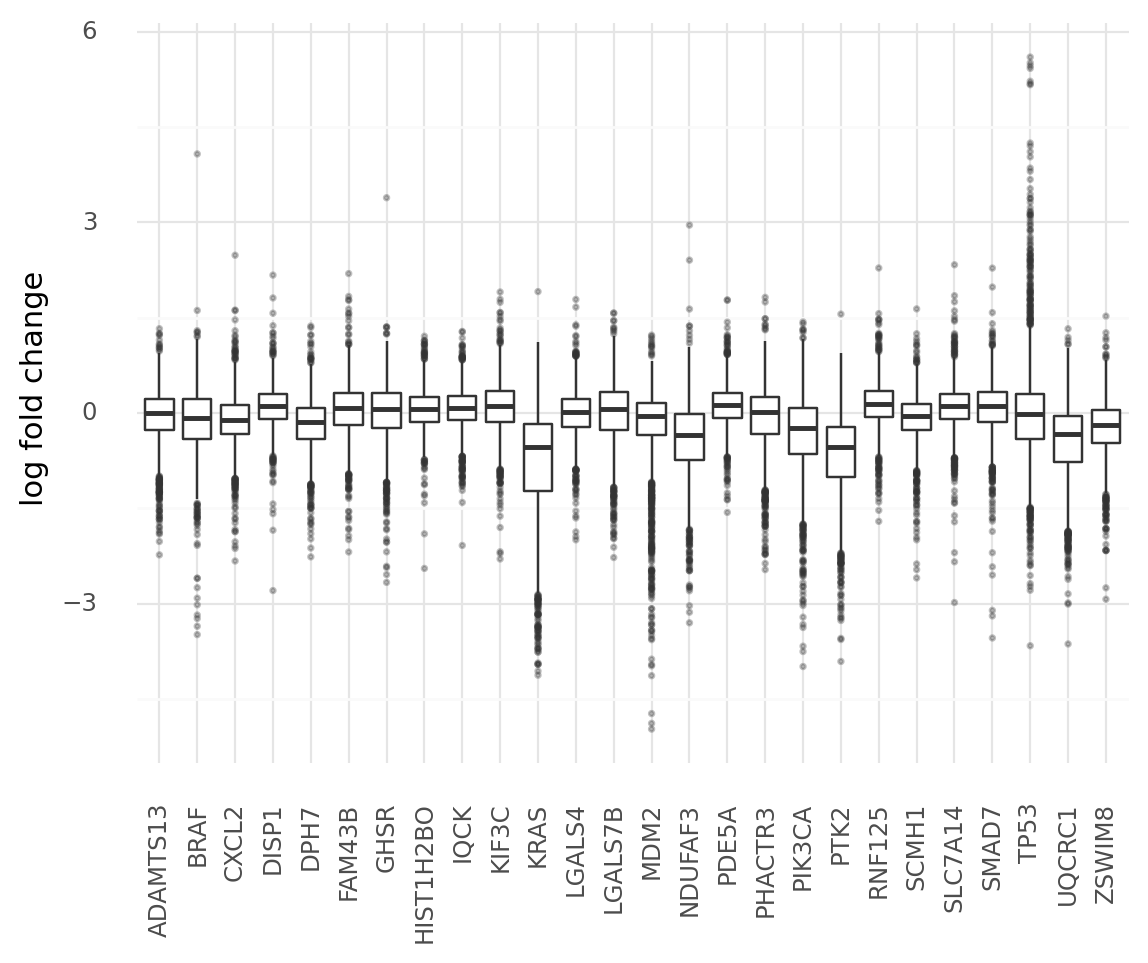

<ggplot: (8779517303712)>

In [6]:
(
    gg.ggplot(data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(outlier_alpha=0.3, outlier_size=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
    + gg.labs(x=None, y="log fold change")
)

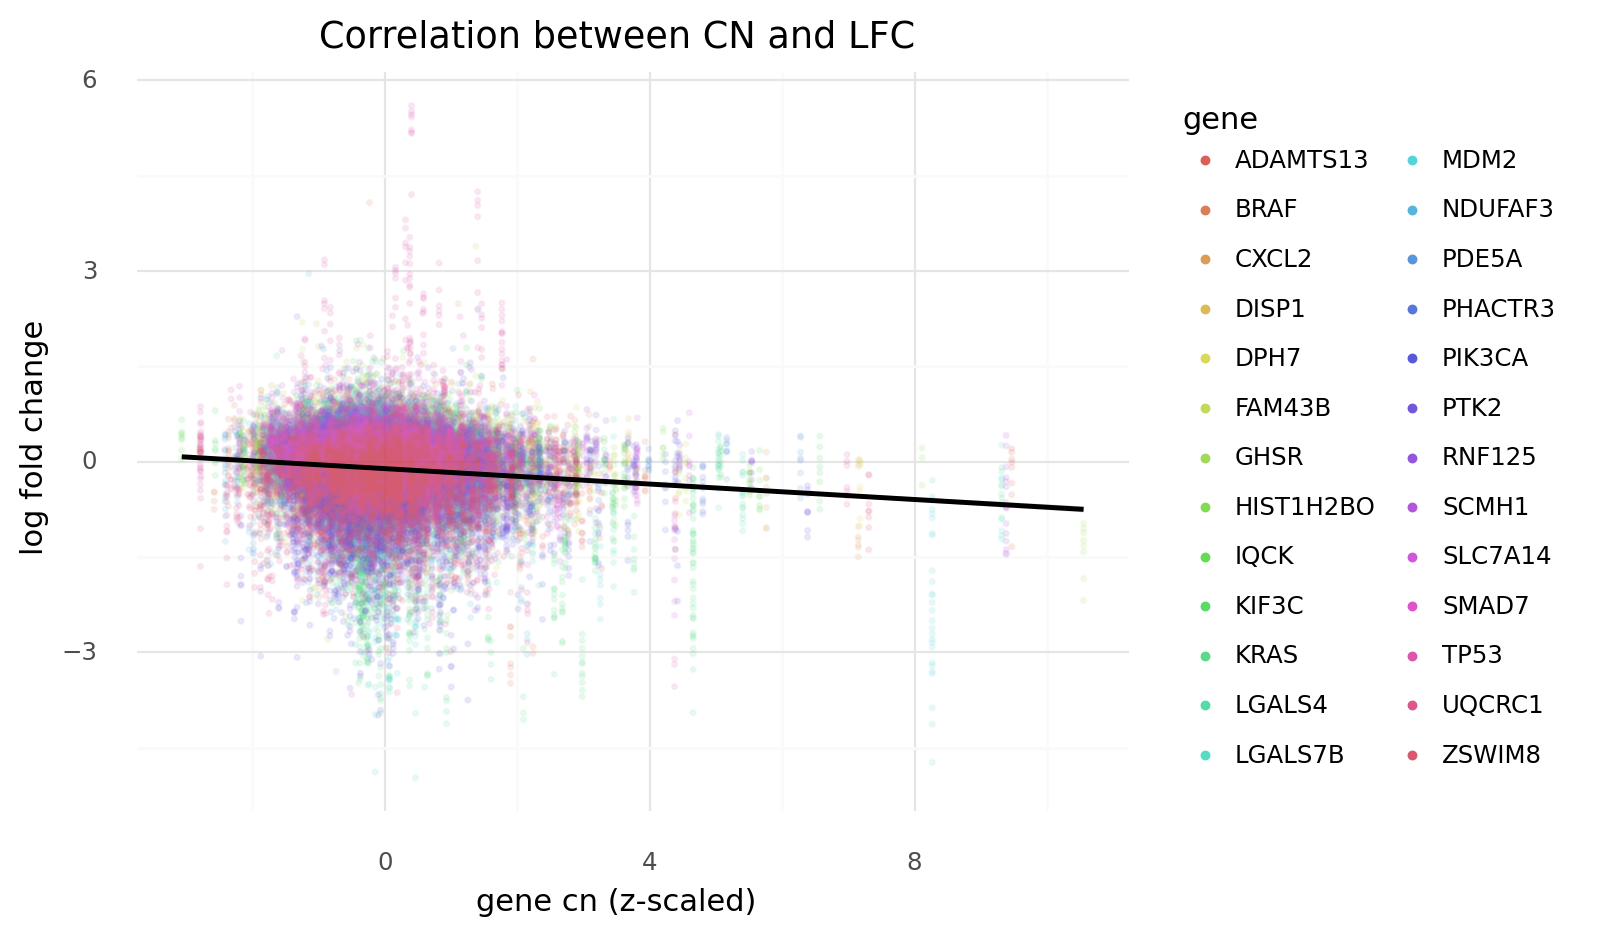

<ggplot: (8779434195824)>

In [7]:
p = (
    gg.ggplot(data, gg.aes(x="gene_cn_z", y="lfc"))
    + gg.geom_point(gg.aes(color="hugo_symbol"), alpha=0.1, size=0.5)
    + gg.geom_smooth()
    + gg.scale_color_discrete(
        guide=gg.guide_legend(override_aes={"size": 1, "alpha": 1})
    )
    + gg.labs(
        x="gene cn (z-scaled)",
        y="log fold change",
        title="Correlation between CN and LFC",
        color="gene",
    )
)
p

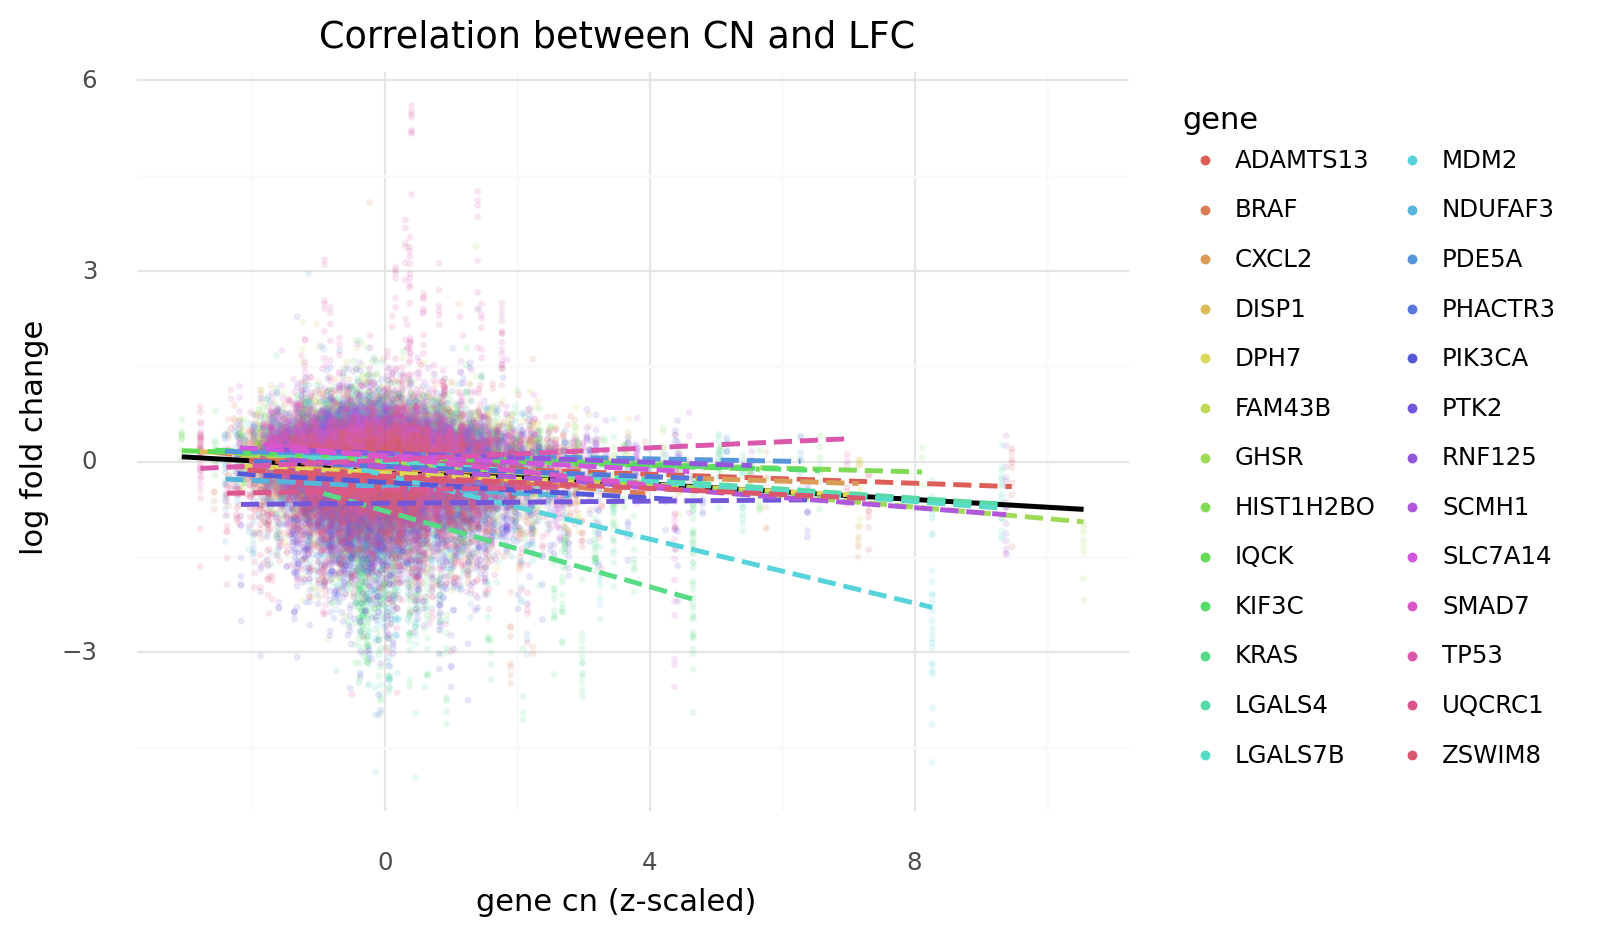

<ggplot: (8779434208449)>

In [8]:
(
    p
    + gg.geom_smooth(
        gg.aes(color="hugo_symbol"),
        linetype="--",
        alpha=0.5,
        se=False,
        show_legend=False,
    )
)

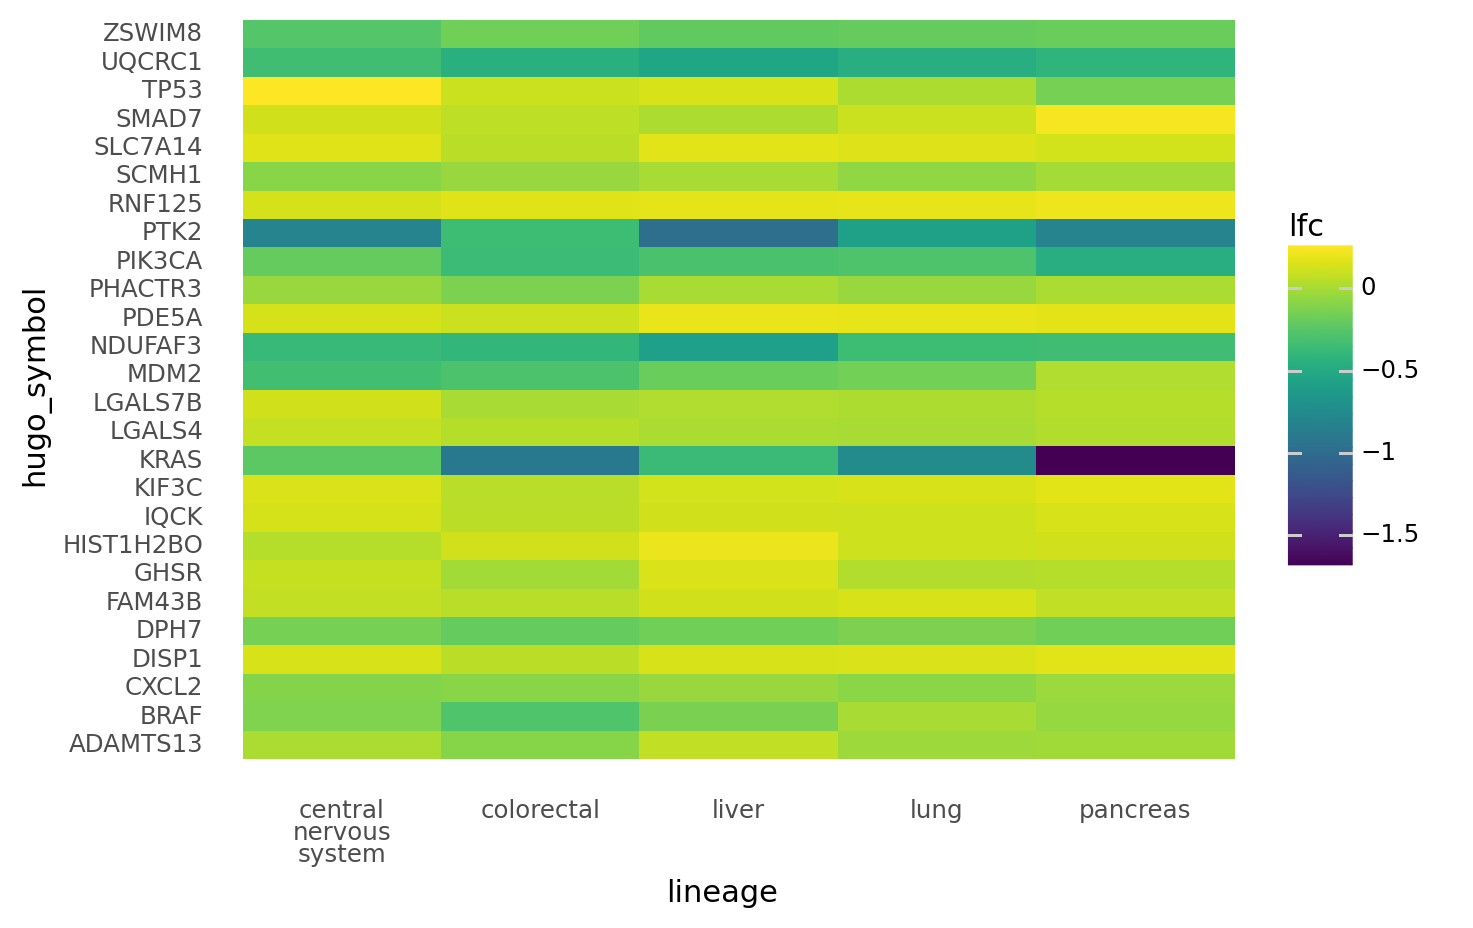

<ggplot: (8779423167287)>

In [9]:
d = data.groupby(["lineage", "hugo_symbol"]).mean().reset_index(drop=False)
d["lineage"] = stringr.str_replace(d["lineage"], "_", " ")
d["lineage"] = stringr.str_wrap(d["lineage"], width=10)

(
    gg.ggplot(d, gg.aes(x="lineage", y="hugo_symbol", fill="lfc"))
    + gg.geom_tile()
    + gg.scale_x_discrete(expand=(0, 0.5, 0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5, 0, 0.5))
)

In [10]:
data.head()

sgrna                    replicate_id       lfc  pdna_batch  \
0  CCACCCACAGACGCTCAGCA    ls513-311cas9_repa_p6_batch2  0.029491           2   
1  CCACCCACAGACGCTCAGCA    ls513-311cas9_repb_p6_batch2  0.426017           2   
2  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep a p5_batch3  0.008626           3   
3  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep b p5_batch3  0.280821           3   
4  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep c p5_batch3  0.239815           3   

   passes_qc   depmap_id primary_or_metastasis     lineage  \
0       True  ACH-000007               Primary  colorectal   
1       True  ACH-000007               Primary  colorectal   
2       True  ACH-000009               Primary  colorectal   
3       True  ACH-000009               Primary  colorectal   
4       True  ACH-000009               Primary  colorectal   

             lineage_subtype kras_mutation  ...   gene_cn  n_muts  \
0  colorectal_adenocarcinoma          G12D  ...  2.632957       0   
1  colorectal_adenocarcinoma          G12D  ...  2.632957       0   
2  colorectal_adenocarcinoma            WT  ...  1.594524       0   
3  colorectal_adenocarcinoma            WT  ...  1.594524       0   
4  colorectal_adenocarcinoma            WT  ...  1.594524       0   

  any_deleterious variant_classification  is_deleterious  is_tcga_hotspot  \
0           False                    NaN             NaN              NaN   
1           False                    NaN             NaN              NaN   
2           False                    NaN             NaN              NaN   
3           False                    NaN             NaN              NaN   
4           False                    NaN             NaN              NaN   

   is_cosmic_hotspot  mutated_at_guide_location  rna_expr  gene_cn_z  
0                NaN                      False  1.480265   1.632215  
1                NaN                      False  1.480265   1.632215  
2                NaN                      False  0.695994  -0.365193  
3                NaN                      False  0.695994  -0.365193  
4                NaN                      False  0.695994  -0.365193  

[5 rows x 28 columns]

---

## Modeling

### Model 1. Hierarchical model by gene with no other variables

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_{g} \\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 5) \\
\sigma_\alpha \sim \text{HalfNormal}(0, 5) \\
\sigma \sim \text{HalfNormal}(0, 5)
$

In [11]:
gene_idx = get_indices(data, "hugo_symbol")
num_genes = data["hugo_symbol"].nunique()
with pm.Model() as m1:
    σ_α = pm.HalfNormal("σ_α", 5.0)
    μ_α = pm.Normal("μ_α", 0, 5)

    α_g = pm.Normal("α_g", μ_α, σ_α, shape=num_genes)
    μ = pm.Deterministic("μ", α_g[gene_idx])
    σ = pm.HalfNormal("σ", 5.0)

    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.lfc)

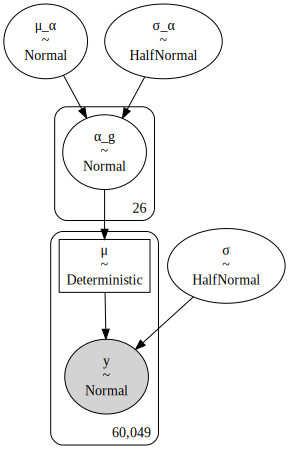

In [12]:
pm.model_to_graphviz(m1)

In [13]:
m1_cache_dir = pymc3_cache_dir / "subset_speclet_m1"

m1_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m1,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m1_cache_dir,
    force=False,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000},
)

Loading cached trace and posterior sample...


In [14]:
m1_az = pmhelp.samples_to_arviz(model=m1, res=m1_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


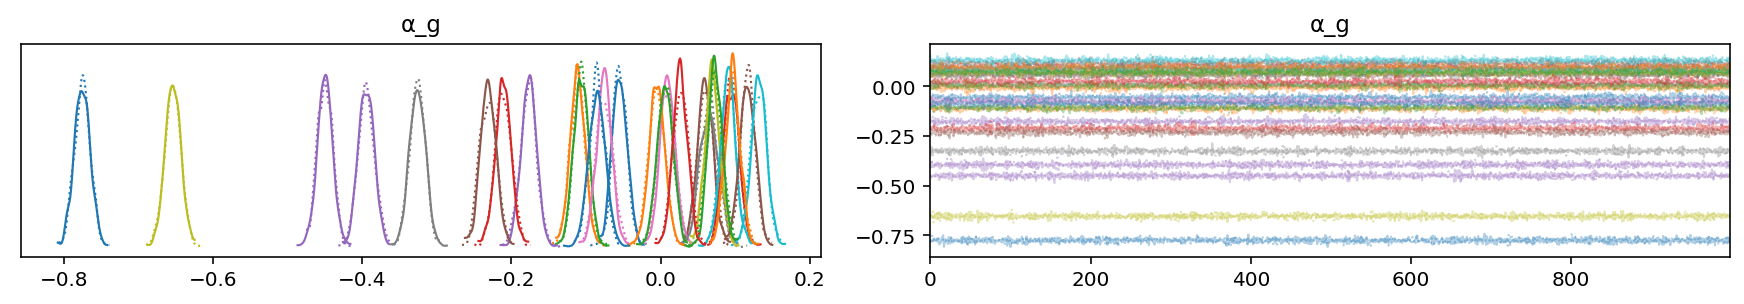

In [15]:
az.plot_trace(m1_az, var_names="α_g", compact=True)
plt.show()

In [16]:
az.summary(m1_az, var_names=["α_g"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α_g[0]  -0.055  0.010  -0.073   -0.036        0.0      0.0    4313.0  4313.0   
α_g[1]  -0.111  0.010  -0.132   -0.094        0.0      0.0    4567.0  4401.0   
α_g[2]  -0.107  0.010  -0.126   -0.088        0.0      0.0    3800.0  3756.0   
α_g[3]   0.094  0.010   0.075    0.113        0.0      0.0    3779.0  3676.0   
α_g[4]  -0.177  0.011  -0.197   -0.157        0.0      0.0    3689.0  3689.0   
α_g[5]   0.060  0.011   0.039    0.079        0.0      0.0    4802.0  4237.0   
α_g[6]   0.009  0.010  -0.011    0.028        0.0      0.0    3388.0  1518.0   
α_g[7]   0.065  0.012   0.043    0.088        0.0      0.0    4077.0  3509.0   
α_g[8]   0.069  0.010   0.051    0.089        0.0      0.0    3038.0  3036.0   
α_g[9]   0.090  0.010   0.070    0.109        0.0      0.0    3592.0  3431.0   
α_g[10] -0.775  0.011  -0.795   -0.756        0.0      0.0    4350.0  4350.0   
α_g[11] -0.005  0.011  -0.024    0.016        0.0      0.0    3689.0   873.0   
α_g[12]  0.006  0.011  -0.012    0.027        0.0      0.0    4356.0  1200.0   
α_g[13] -0.211  0.011  -0.232   -0.190        0.0      0.0    4614.0  4613.0   
α_g[14] -0.394  0.011  -0.415   -0.375        0.0      0.0    4111.0  4078.0   
α_g[15]  0.117  0.010   0.098    0.136        0.0      0.0    3779.0  3779.0   
α_g[16] -0.076  0.011  -0.097   -0.056        0.0      0.0    6602.0  6278.0   
α_g[17] -0.326  0.010  -0.346   -0.307        0.0      0.0    3796.0  3748.0   
α_g[18] -0.654  0.011  -0.672   -0.632        0.0      0.0    4896.0  4852.0   
α_g[19]  0.132  0.010   0.113    0.153        0.0      0.0    4328.0  4192.0   
α_g[20] -0.085  0.011  -0.104   -0.064        0.0      0.0    4110.0  3942.0   
α_g[21]  0.096  0.010   0.076    0.114        0.0      0.0    3997.0  3900.0   
α_g[22]  0.073  0.010   0.055    0.092        0.0      0.0    5721.0  5355.0   
α_g[23]  0.026  0.010   0.007    0.046        0.0      0.0    4642.0  2591.0   
α_g[24] -0.450  0.010  -0.468   -0.430        0.0      0.0    4651.0  4651.0   
α_g[25] -0.231  0.011  -0.251   -0.211        0.0      0.0    3723.0  3723.0   

         ess_bulk  ess_tail  r_hat  
α_g[0]     4292.0    1314.0   1.00  
α_g[1]     4552.0    1031.0   1.00  
α_g[2]     3805.0    1332.0   1.00  
α_g[3]     3804.0    1266.0   1.00  
α_g[4]     3726.0    1335.0   1.00  
α_g[5]     4833.0    1550.0   1.00  
α_g[6]     3394.0    1288.0   1.00  
α_g[7]     4168.0    1133.0   1.00  
α_g[8]     3028.0    1474.0   1.00  
α_g[9]     3576.0    1309.0   1.00  
α_g[10]    4288.0    1441.0   1.00  
α_g[11]    3665.0    1358.0   1.00  
α_g[12]    4380.0    1508.0   1.00  
α_g[13]    4575.0    1326.0   1.00  
α_g[14]    4062.0    1334.0   1.00  
α_g[15]    3763.0    1303.0   1.00  
α_g[16]    6602.0    1352.0   1.01  
α_g[17]    3829.0    1355.0   1.00  
α_g[18]    4427.0    1307.0   1.00  
α_g[19]    4332.0    1105.0   1.00  
α_g[20]    4153.0    1423.0   1.00  
α_g[21]    4039.0    1488.0   1.00  
α_g[22]    5741.0    1494.0   1.00  
α_g[23]    4658.0    1199.0   1.01  
α_g[24]    4646.0    1417.0   1.00  
α_g[25]    3750.0    1609.0   1.00

In [17]:
def calculate_hdi_labels(hdi_prob: float, prefix: str = "hdi_") -> Tuple[str, str]:
    low = 100 * (1 - hdi_prob) / 2
    high = 100 - low
    return f"{prefix}{low:.1f}%", f"{prefix}{high:.1f}%"


def logfc_model_ppc_dataframe(
    az_obj: az.InferenceData,
    real_values: pd.Series,
    to_merge_with: Optional[pd.DataFrame] = None,
    hdi_prob: float = 0.89,
    var_name: str = "y",
) -> pd.DataFrame:
    ppc_arry = np.asarray(az_obj.posterior_predictive[var_name]).squeeze()
    ppc_summary = pd.DataFrame(
        az.hdi(ppc_arry, hdi_prob=hdi_prob), columns=calculate_hdi_labels(hdi_prob)
    )
    ppc_summary["mean"] = np.mean(ppc_arry, axis=0)
    ppc_summary = ppc_summary.reset_index(drop=True)
    ppc_summary["real_value"] = real_values
    ppc_summary["error"] = ppc_summary["mean"] - ppc_summary["real_value"]

    if not to_merge_with is None:
        ppc_summary = ppc_summary.merge(
            to_merge_with.reset_index(drop=True), left_index=True, right_index=True
        )

    return ppc_summary

In [18]:
ppc_m1_summary = logfc_model_ppc_dataframe(
    m1_az, data.lfc, data[["hugo_symbol", "sgrna", "depmap_id"]]
)
ppc_m1_summary.head()

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


hdi_5.5%  hdi_94.5%      mean  real_value     error hugo_symbol  \
0 -0.857051   0.772856 -0.041082    0.029491 -0.070573    ADAMTS13   
1 -0.887173   0.771502 -0.062950    0.426017 -0.488967    ADAMTS13   
2 -0.901727   0.750155 -0.073091    0.008626 -0.081717    ADAMTS13   
3 -0.847794   0.798100 -0.032507    0.280821 -0.313328    ADAMTS13   
4 -0.903893   0.742157 -0.034015    0.239815 -0.273830    ADAMTS13   

                  sgrna   depmap_id  
0  CCACCCACAGACGCTCAGCA  ACH-000007  
1  CCACCCACAGACGCTCAGCA  ACH-000007  
2  CCACCCACAGACGCTCAGCA  ACH-000009  
3  CCACCCACAGACGCTCAGCA  ACH-000009  
4  CCACCCACAGACGCTCAGCA  ACH-000009

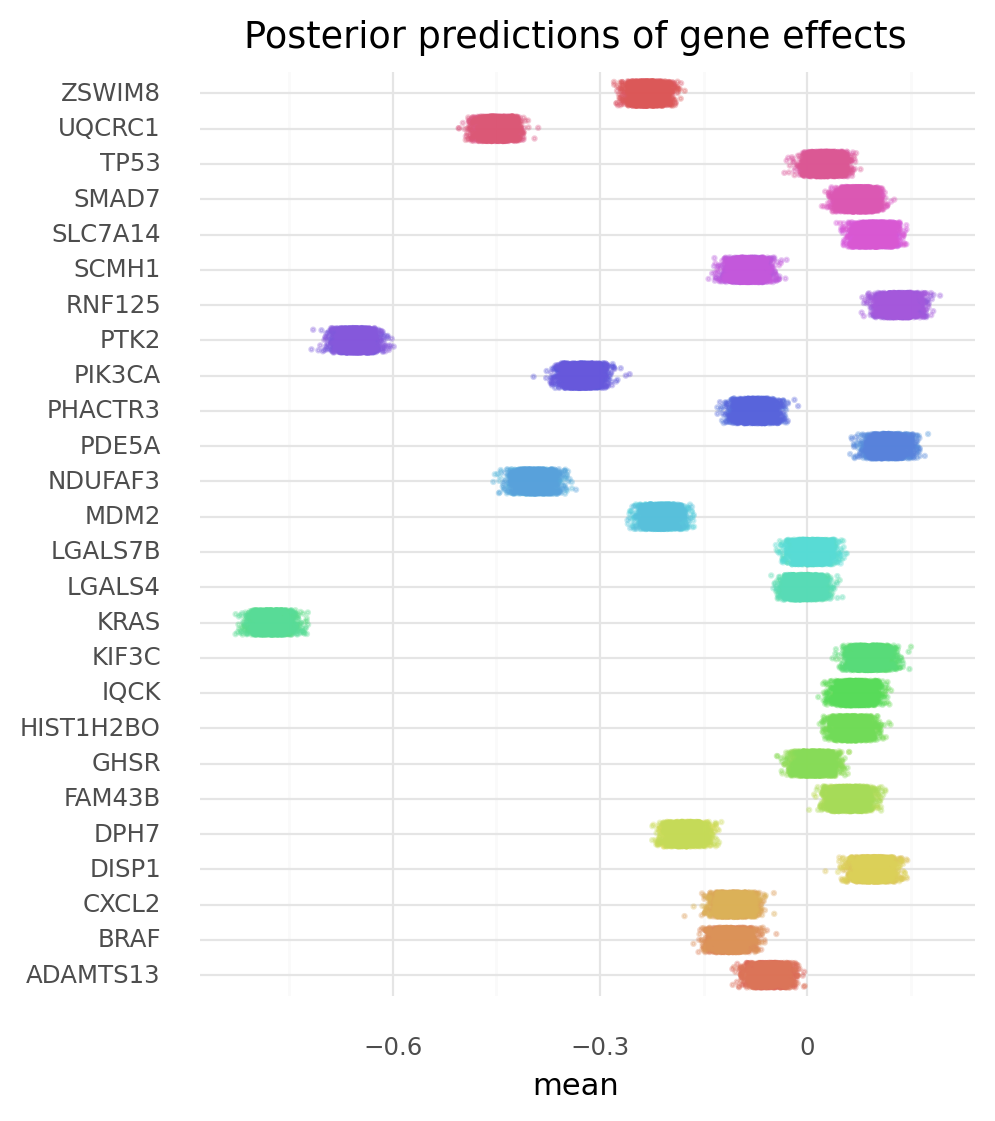

<ggplot: (8779201247428)>

In [19]:
p = (
    gg.ggplot(ppc_m1_summary, gg.aes(y="hugo_symbol"))
    + gg.geom_jitter(
        gg.aes(x="mean", color="sgrna"), width=0, height=0.35, alpha=0.3, size=0.3
    )
    + gg.scale_color_discrete(guide=None)
    + gg.theme(figure_size=(5, 6))
    + gg.labs(x="mean", y=None, title="Posterior predictions of gene effects")
)

p

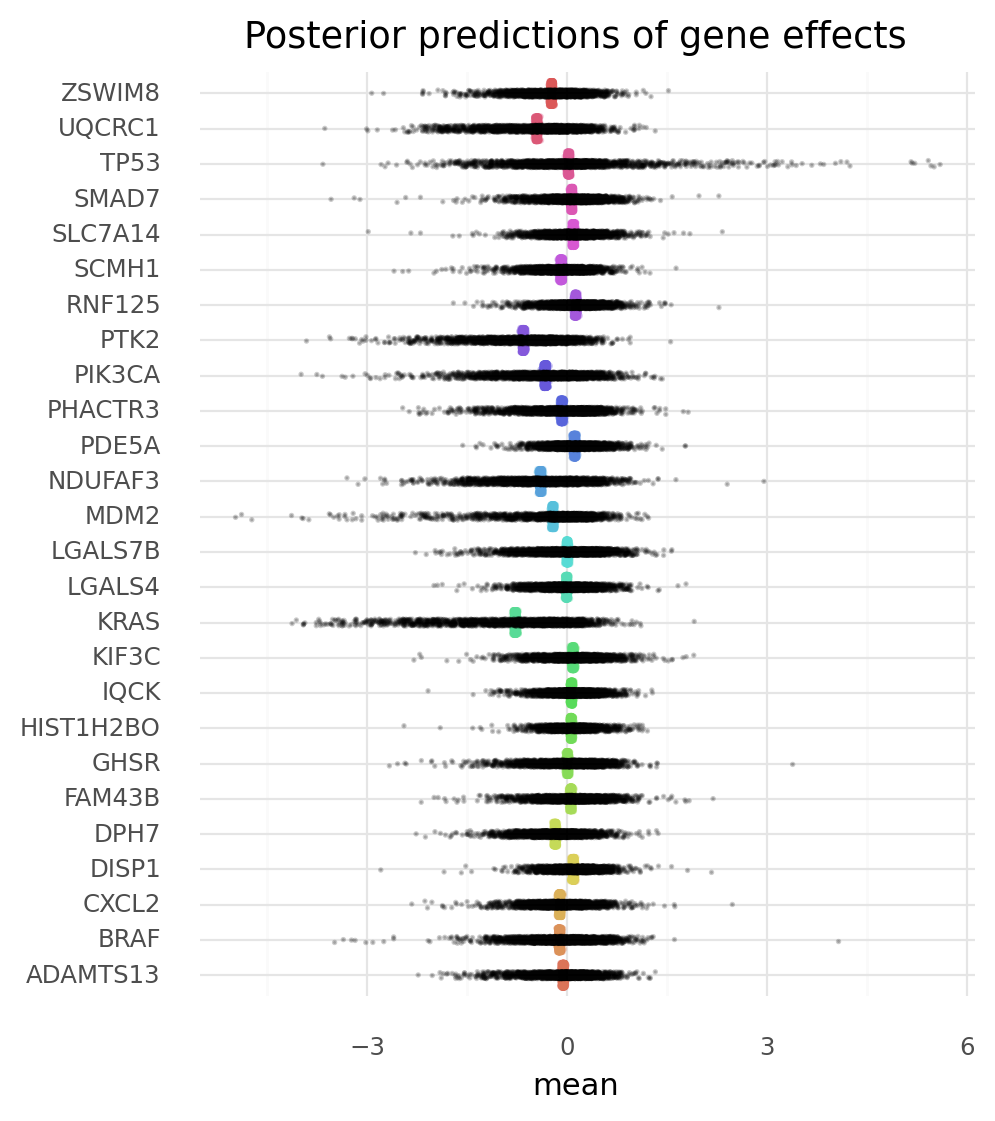

<ggplot: (8779201776788)>

In [20]:
(p + gg.geom_jitter(gg.aes(x="real_value"), alpha=0.2, size=0.1, height=0.1, width=0))

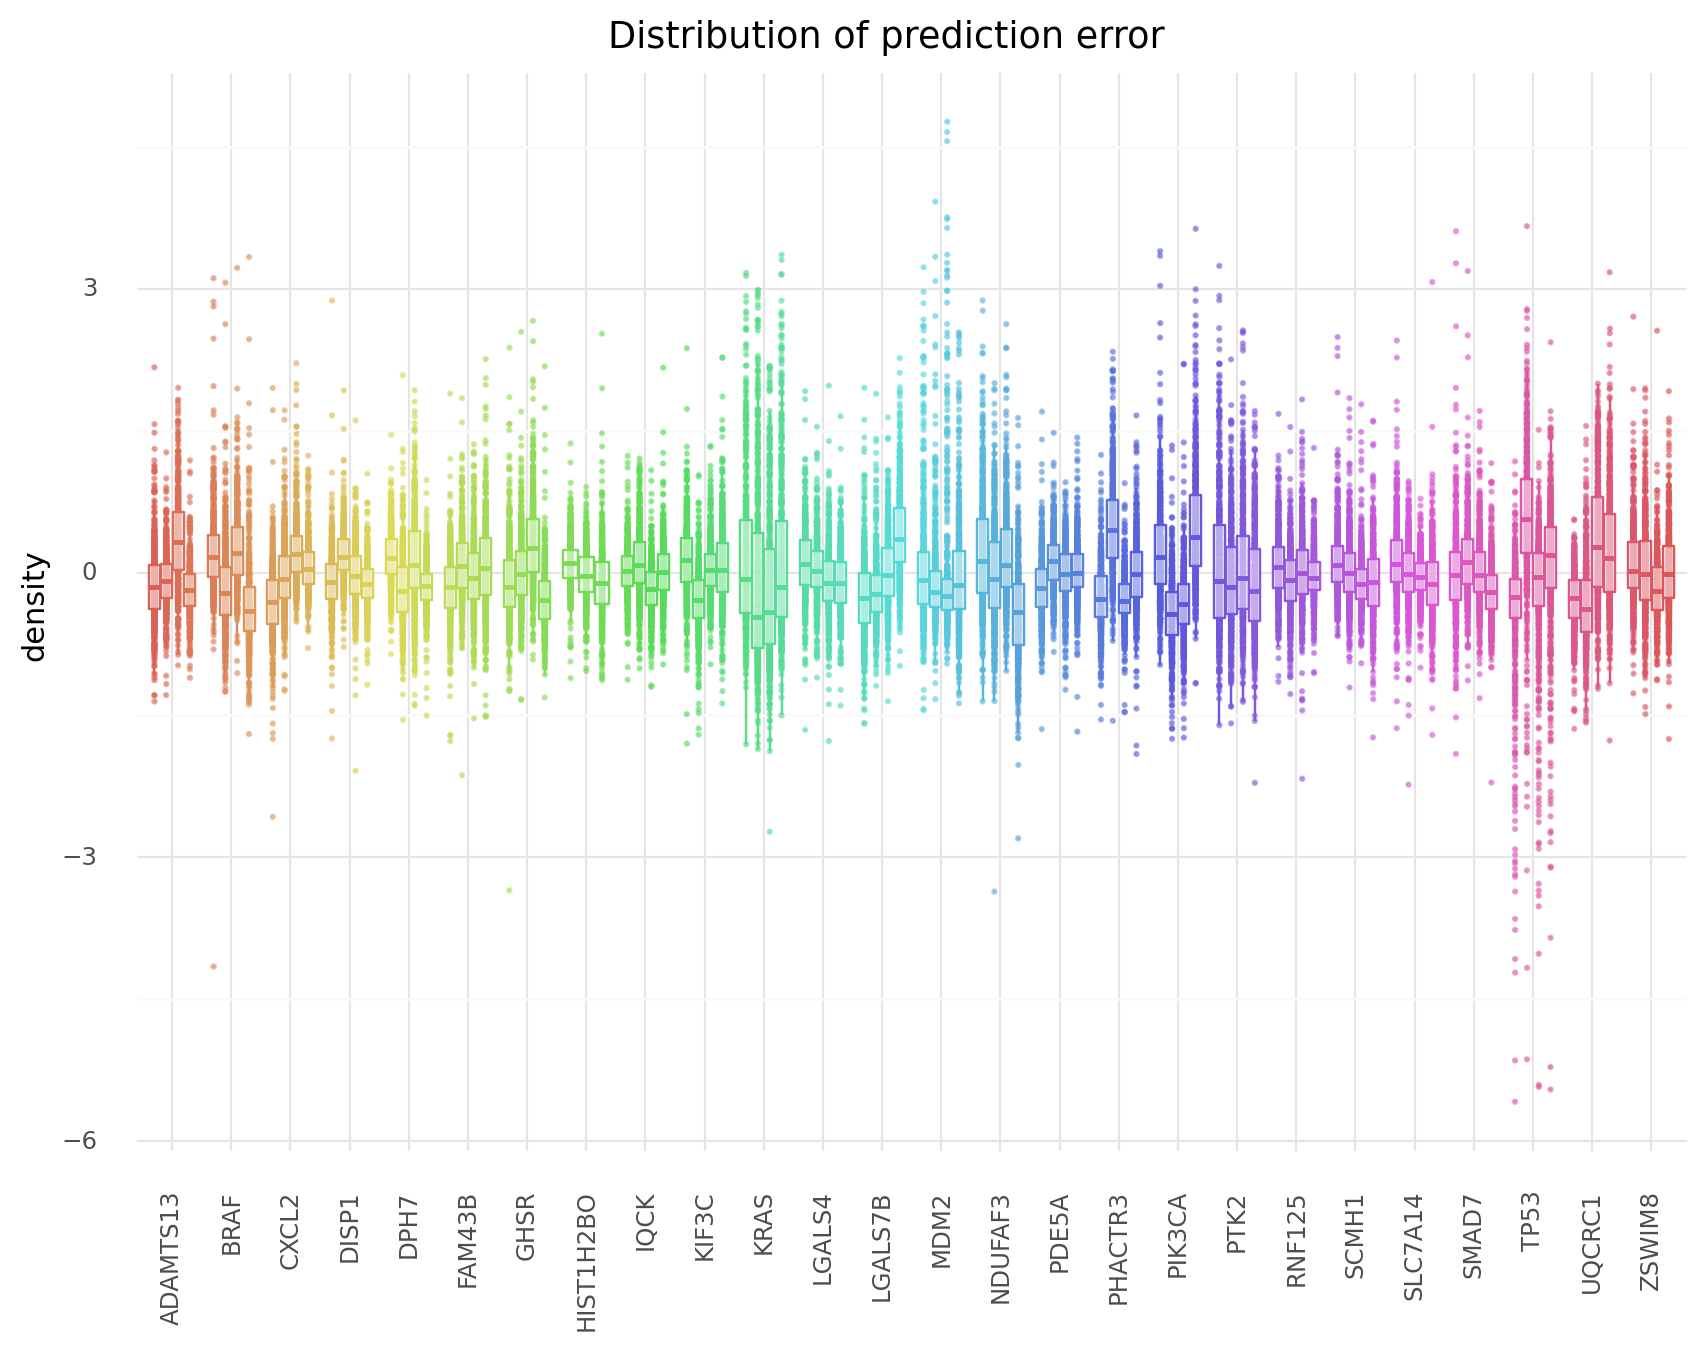

<ggplot: (8779201086118)>

In [21]:
(
    gg.ggplot(ppc_m1_summary, gg.aes(y="error", x="hugo_symbol"))
    + gg.geom_point(
        gg.aes(color="sgrna"),
        position=gg.position_jitterdodge(
            jitter_width=0.2, jitter_height=0, dodge_width=0.8, random_state=RANDOM_SEED
        ),
        alpha=0.5,
        size=0.3,
    )
    + gg.geom_boxplot(
        gg.aes(color="sgrna"),
        position=gg.position_dodge(width=0.8),
        outlier_alpha=0,
        alpha=0.5,
        fill="white",
    )
    + gg.scale_color_discrete(guide=None)
    + gg.theme(figure_size=(10, 7), axis_text_x=gg.element_text(angle=90))
    + gg.labs(x=None, y="density", title="Distribution of prediction error")
)

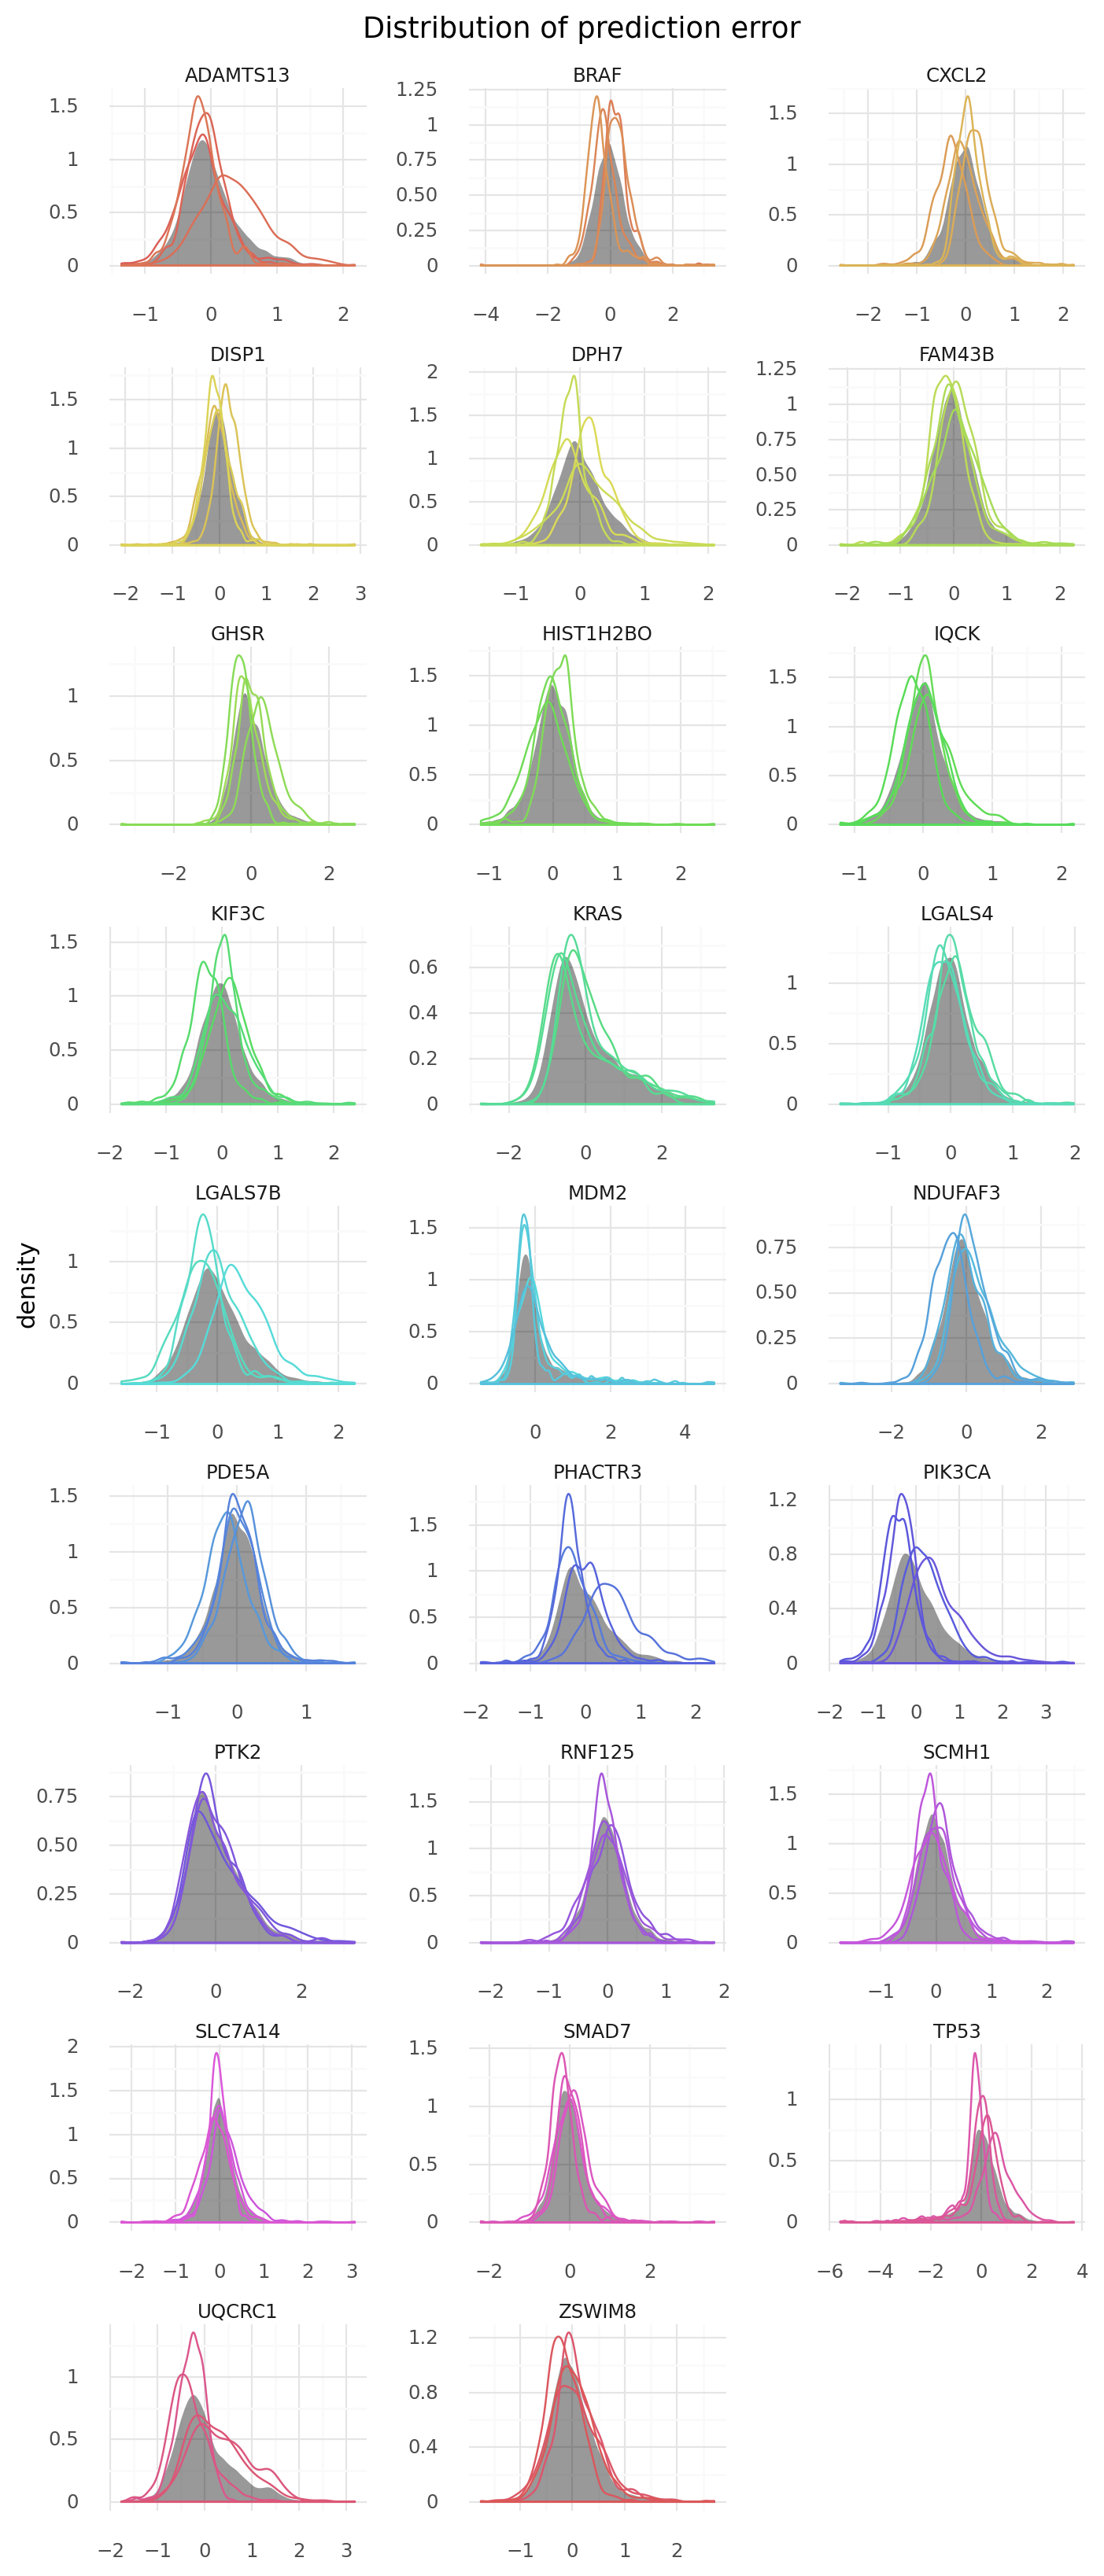

<ggplot: (8779489965526)>

In [22]:
(
    gg.ggplot(ppc_m1_summary, gg.aes(x="error"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=3)
    + gg.geom_density(fill="black", color=None, alpha=0.4)
    + gg.geom_density(gg.aes(color="sgrna"), fill=None)
    + gg.scale_color_discrete(guide=None)
    + gg.theme(figure_size=(8, 20), subplots_adjust={"hspace": 0.5, "wspace": 0.4})
    + gg.labs(x=None, y="density", title="Distribution of prediction error")
)

---

### Model 2. Add a layer for gene above sgRNA

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_s \\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_{\alpha_s}) \\
\qquad \mu_{\alpha_s} = g_s \\
\qquad \quad g_s \sim \mathcal{N}(\mu_g, \sigma_g) \\
\qquad \qquad \mu_g \sim \mathcal{N}(0, 5) \quad \sigma_g \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\sigma \sim \text{HalfNormal}(5)
$

In [23]:
num_sgrnas = data["sgrna"].nunique()
num_genes = data["hugo_symbol"].nunique()
print(f"{num_sgrnas} sgRNAs from {num_genes} genes")

sgrna_idx = get_indices(data, "sgrna")

sgrna_to_gene_map = data[["sgrna", "hugo_symbol"]].drop_duplicates()
gene_idx = get_indices(sgrna_to_gene_map, "hugo_symbol")

103 sgRNAs from 26 genes


In [24]:
with pm.Model() as m2:
    μ_g = pm.Normal("μ_g", 0, 5)
    σ_g = pm.Exponential("σ_g", 1)

    g_s = pm.Normal("g_s", μ_g, σ_g, shape=num_genes)

    μ_α_s = pm.Deterministic("μ_α_s", g_s[gene_idx])
    σ_α_s = pm.Exponential("σ_α_s", 1)

    α_s = pm.Normal("α_s", μ_α_s, σ_α_s, shape=num_sgrnas)

    μ = pm.Deterministic("μ", α_s[sgrna_idx])
    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=data.lfc)

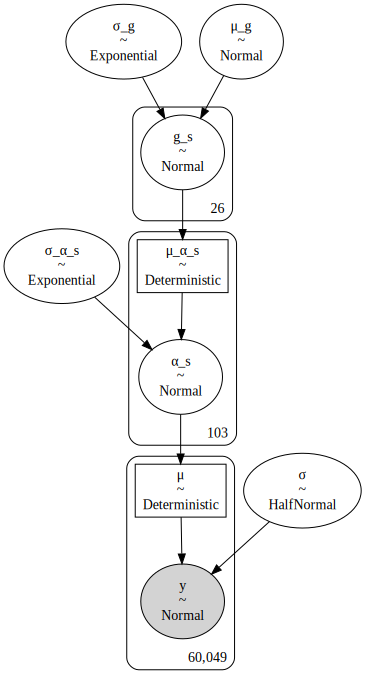

In [25]:
pm.model_to_graphviz(m2)

In [26]:
m2_cache_dir = pymc3_cache_dir / "subset_speclet_m2"

m2_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m2,
    num_mcmc=2000,
    tune=4000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m2_cache_dir,
    force=False,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000, "target_accept": 0.9},
)

Loading cached trace and posterior sample...


In [27]:
m2_az = pmhelp.samples_to_arviz(model=m2, res=m2_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


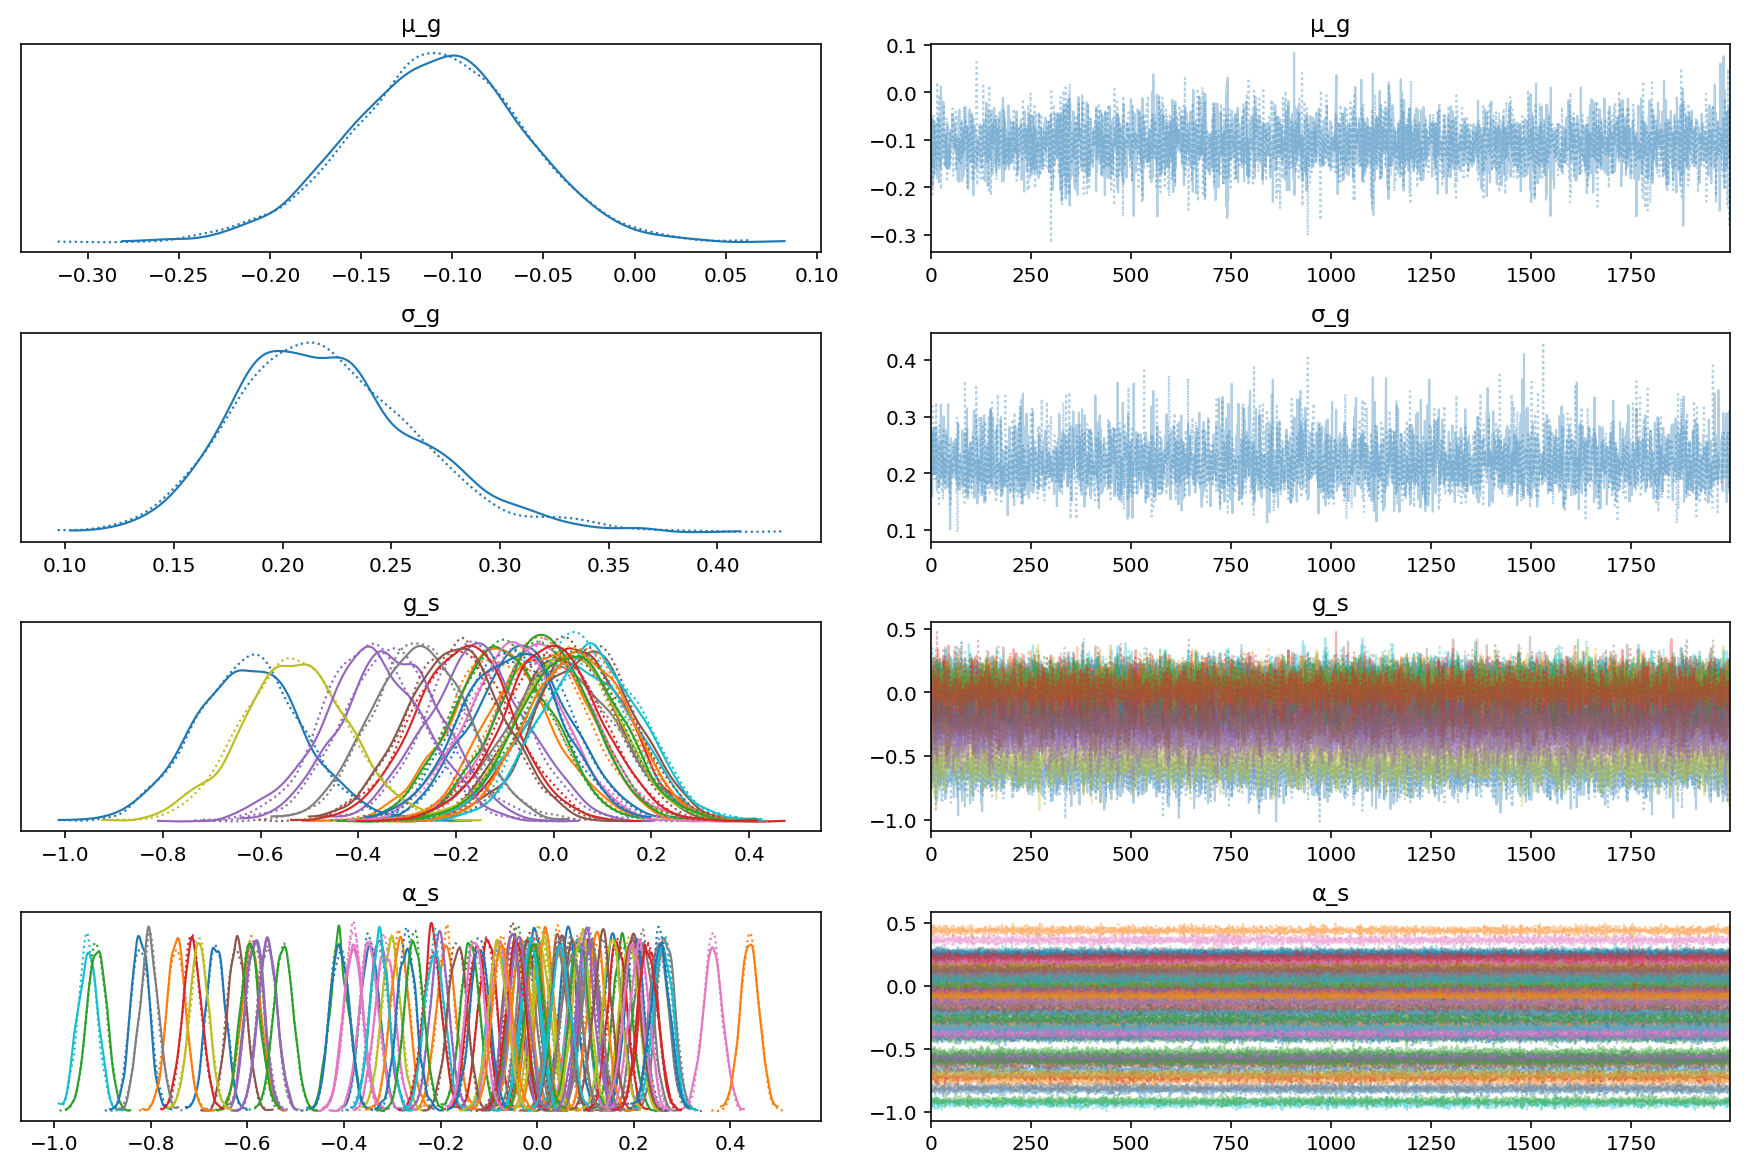

In [28]:
az.plot_trace(m2_az, var_names=["μ_g", "σ_g", "g_s", "α_s"], compact=True)
plt.show()

In [29]:
az.summary(m2_az, var_names=["μ_g", "σ_g", "σ_α_s"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ_g   -0.109  0.049  -0.198   -0.013      0.001      0.0    7060.0  5293.0   
σ_g    0.221  0.043   0.145    0.302      0.001      0.0    4759.0  4728.0   
σ_α_s  0.228  0.019   0.194    0.264      0.000      0.0    4422.0  4389.0   

       ess_bulk  ess_tail  r_hat  
μ_g      7127.0    3154.0    1.0  
σ_g      4693.0    3332.0    1.0  
σ_α_s    4436.0    3350.0    1.0

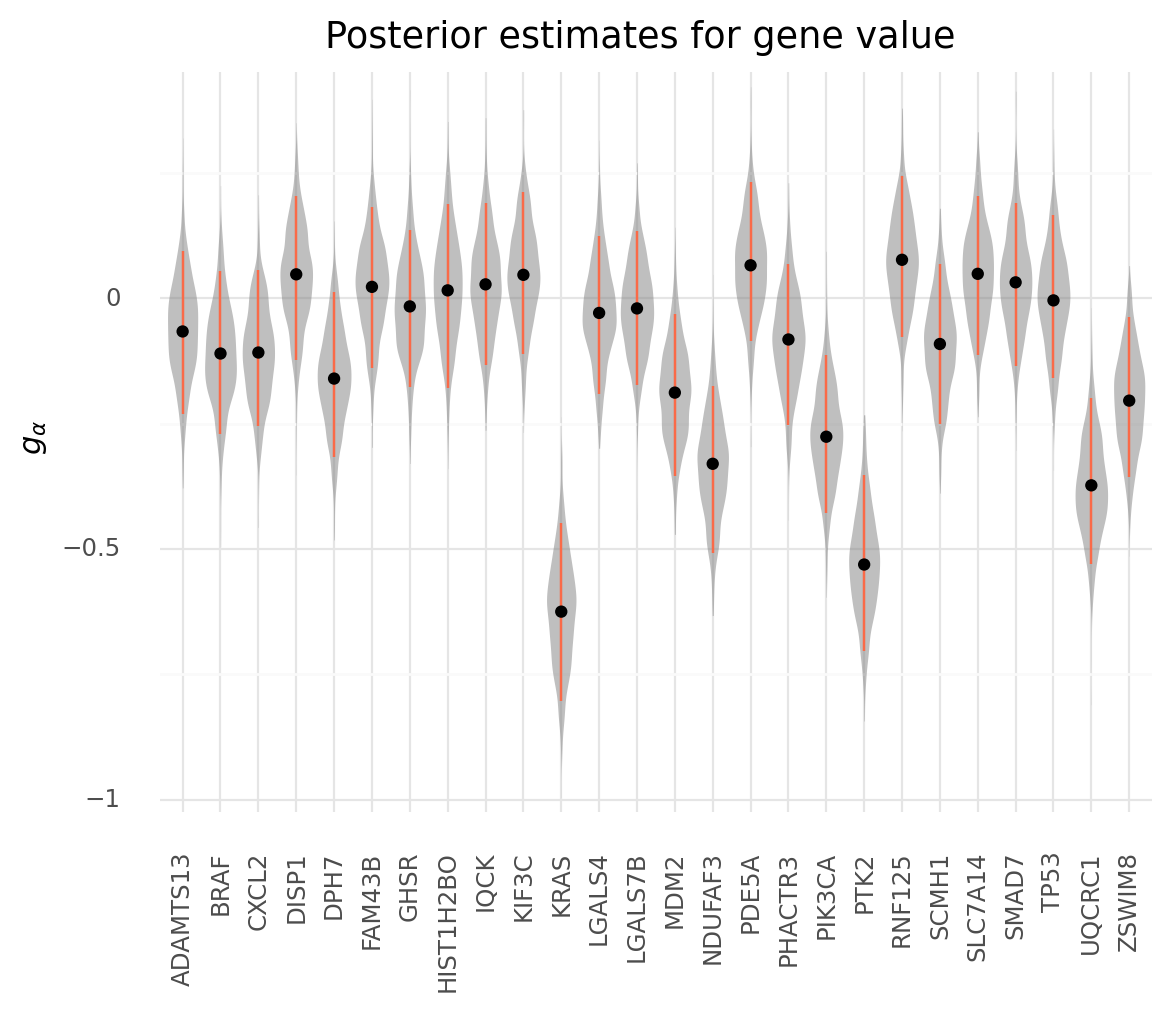

<ggplot: (8779433427556)>

In [30]:
g_alpha_post = pd.DataFrame(np.asarray(m2_az.posterior["g_s"]).reshape(-1, num_genes))
ordered_genes = (
    sgrna_to_gene_map.sort_values("hugo_symbol").hugo_symbol.drop_duplicates().to_list()
)
g_alpha_post.columns = ordered_genes
g_alpha_post = g_alpha_post.melt(var_name="hugo_symbol", value_name="value")

g_alpha_summary = az.summary(m2_az, var_names="g_s", kind="stats", hdi_prob=0.89)
g_alpha_summary["hugo_symbol"] = ordered_genes

point_color = "#FA6A48"
(
    gg.ggplot(g_alpha_post.sample(frac=0.25), gg.aes(x="hugo_symbol", y="value"))
    + gg.geom_violin(color=None, fill="grey", alpha=0.5)
    + gg.geom_linerange(
        gg.aes(x="hugo_symbol", y="mean", ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=g_alpha_summary,
        color=point_color,
    )
    + gg.geom_point(
        gg.aes(x="hugo_symbol", y="mean"), data=g_alpha_summary, color="black"
    )
    + gg.scale_y_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x=None, y=r"$g_\alpha$", title="Posterior estimates for gene value")
)

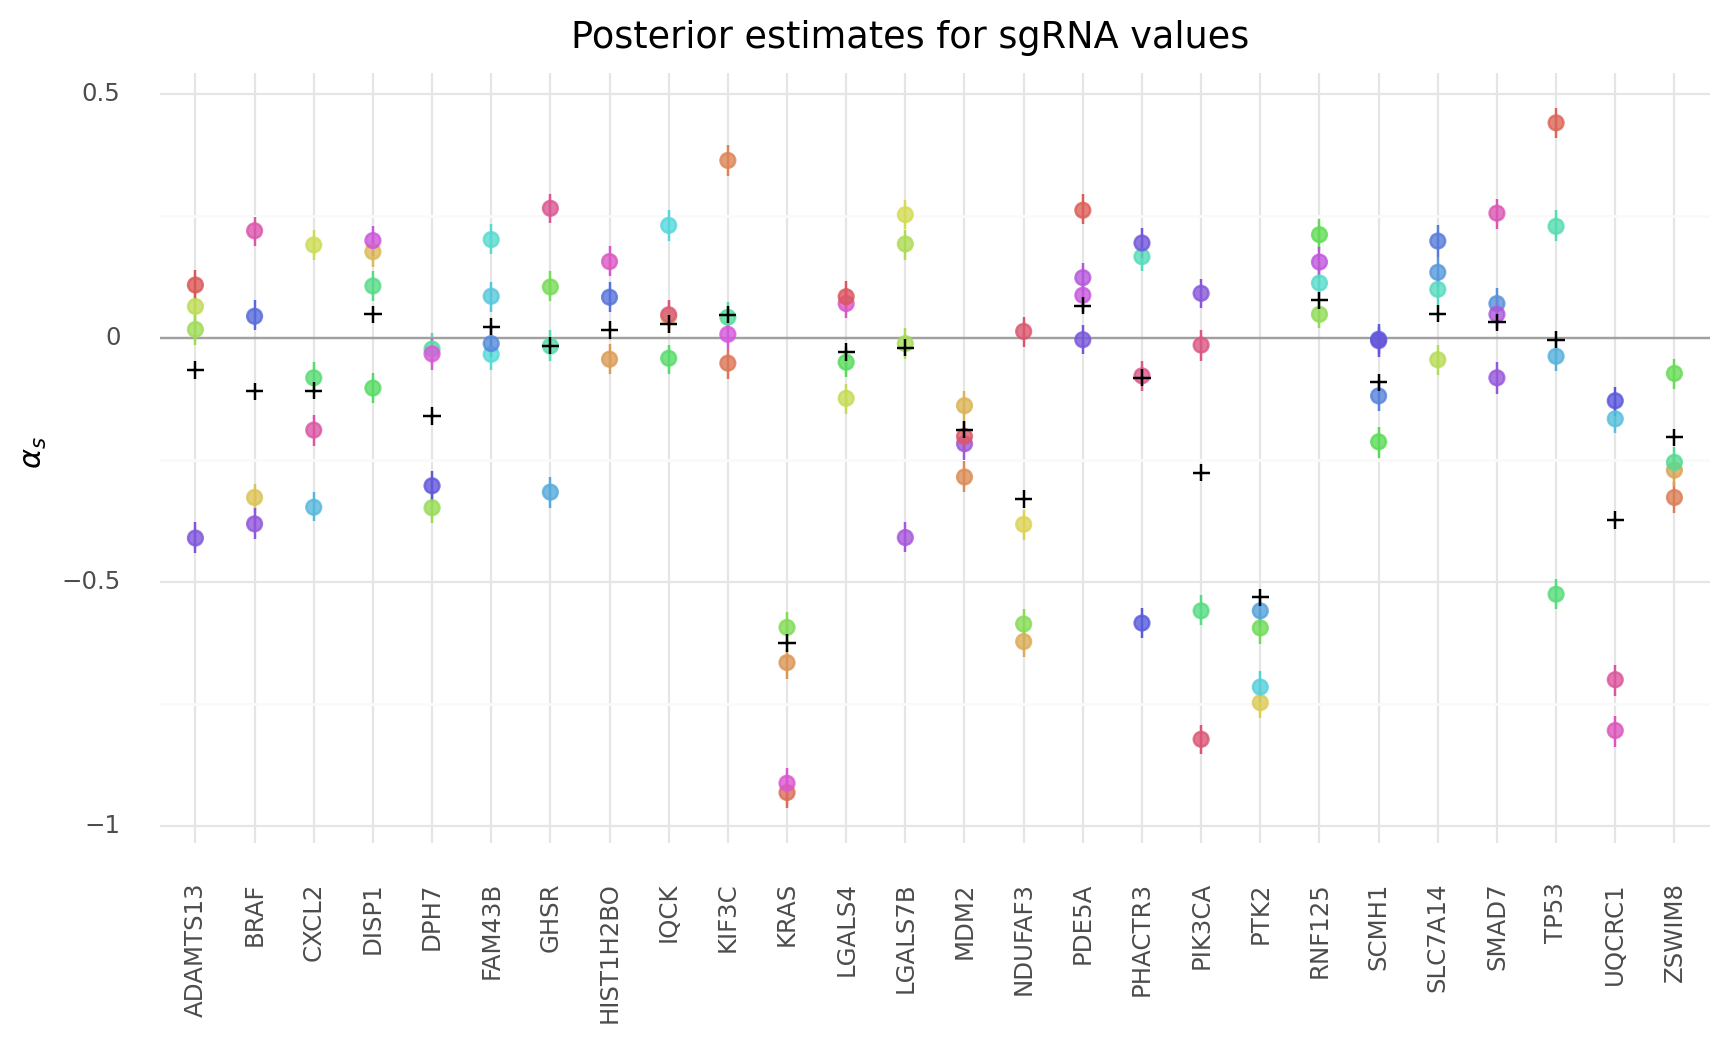

<ggplot: (8779433464025)>

In [31]:
alpha_s_summary = az.summary(m2_az, var_names="α_s", kind="stats", hdi_prob=0.89)
alpha_s_summary["sgrna"] = sgrna_to_gene_map.sgrna.to_list()
alpha_s_summary["hugo_symbol"] = sgrna_to_gene_map.hugo_symbol.to_list()

(
    gg.ggplot(alpha_s_summary, gg.aes(x="hugo_symbol"))
    + gg.geom_hline(yintercept=0, color="black", alpha=0.3)
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="sgrna"))
    + gg.geom_point(gg.aes(y="mean", color="sgrna"), size=2.5, alpha=0.8)
    + gg.geom_point(
        gg.aes(x="hugo_symbol", y="mean"),
        data=g_alpha_summary,
        color="black",
        shape="+",
        size=3,
    )
    + gg.scale_color_discrete(guide=None)
    + gg.theme(figure_size=(10, 5), axis_text_x=gg.element_text(angle=90))
    + gg.labs(x=None, y=r"$\alpha_s$", title="Posterior estimates for sgRNA values")
)

In [32]:
ppc_m2_summary = logfc_model_ppc_dataframe(
    m2_az, data.lfc, data[["hugo_symbol", "sgrna", "depmap_id"]]
)
ppc_m2_summary.head()

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


hdi_5.5%  hdi_94.5%      mean  real_value     error hugo_symbol  \
0 -0.720048   0.802219  0.076820    0.029491  0.047328    ADAMTS13   
1 -0.697091   0.835492  0.056530    0.426017 -0.369487    ADAMTS13   
2 -0.707099   0.810758  0.047157    0.008626  0.038531    ADAMTS13   
3 -0.677088   0.847100  0.084787    0.280821 -0.196034    ADAMTS13   
4 -0.732314   0.790155  0.083411    0.239815 -0.156404    ADAMTS13   

                  sgrna   depmap_id  
0  CCACCCACAGACGCTCAGCA  ACH-000007  
1  CCACCCACAGACGCTCAGCA  ACH-000007  
2  CCACCCACAGACGCTCAGCA  ACH-000009  
3  CCACCCACAGACGCTCAGCA  ACH-000009  
4  CCACCCACAGACGCTCAGCA  ACH-000009

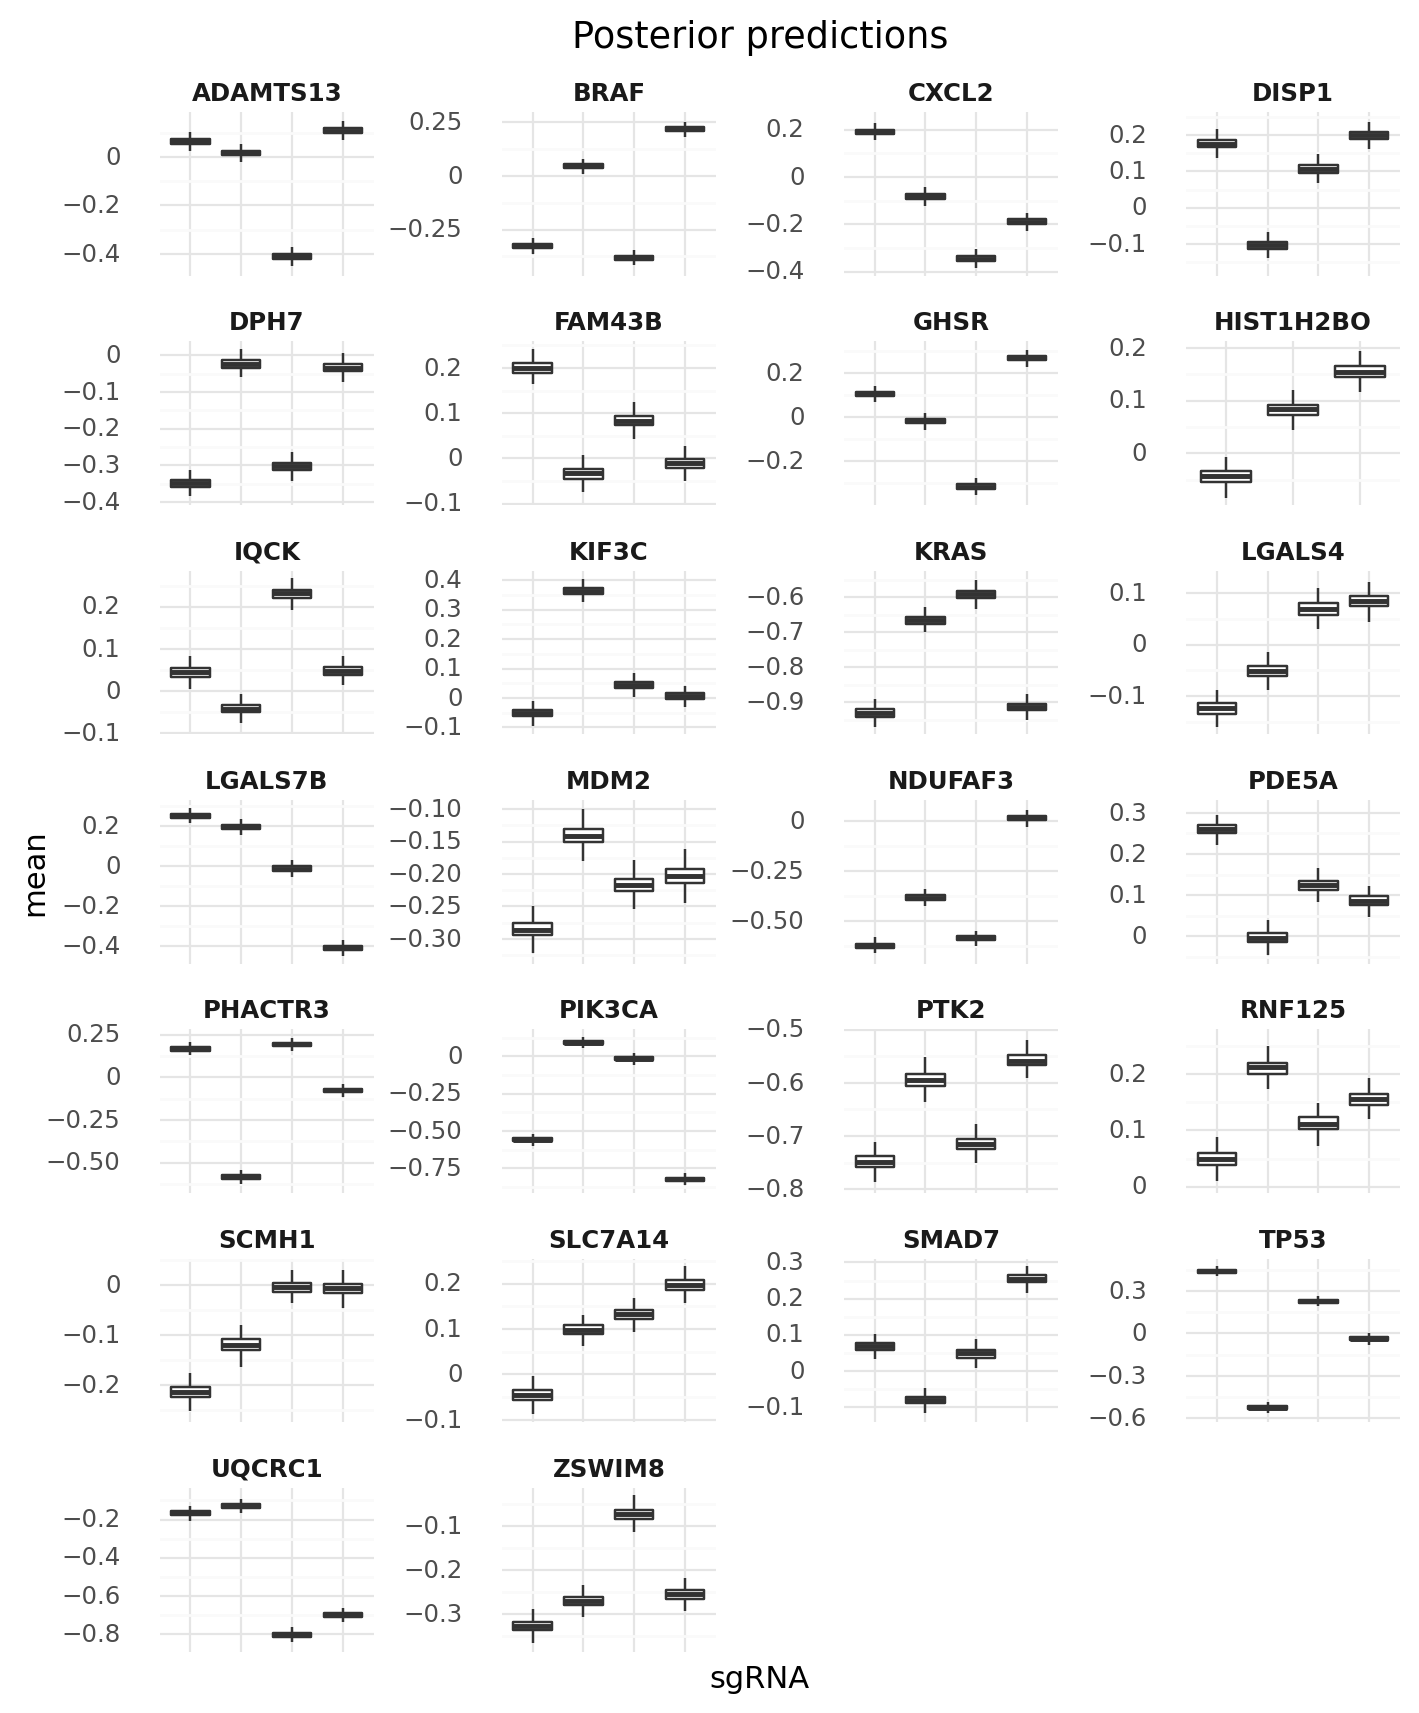

<ggplot: (8779433508807)>

In [33]:
(
    gg.ggplot(ppc_m2_summary, gg.aes(x="sgrna"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=4)
    + gg.geom_boxplot(gg.aes(y="mean"), outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(8, 10),
        subplots_adjust={"hspace": 0.4, "wspace": 0.6},
        strip_text=gg.element_text(weight="bold"),
    )
    + gg.labs(x="sgRNA", y="mean", title="Posterior predictions")
)

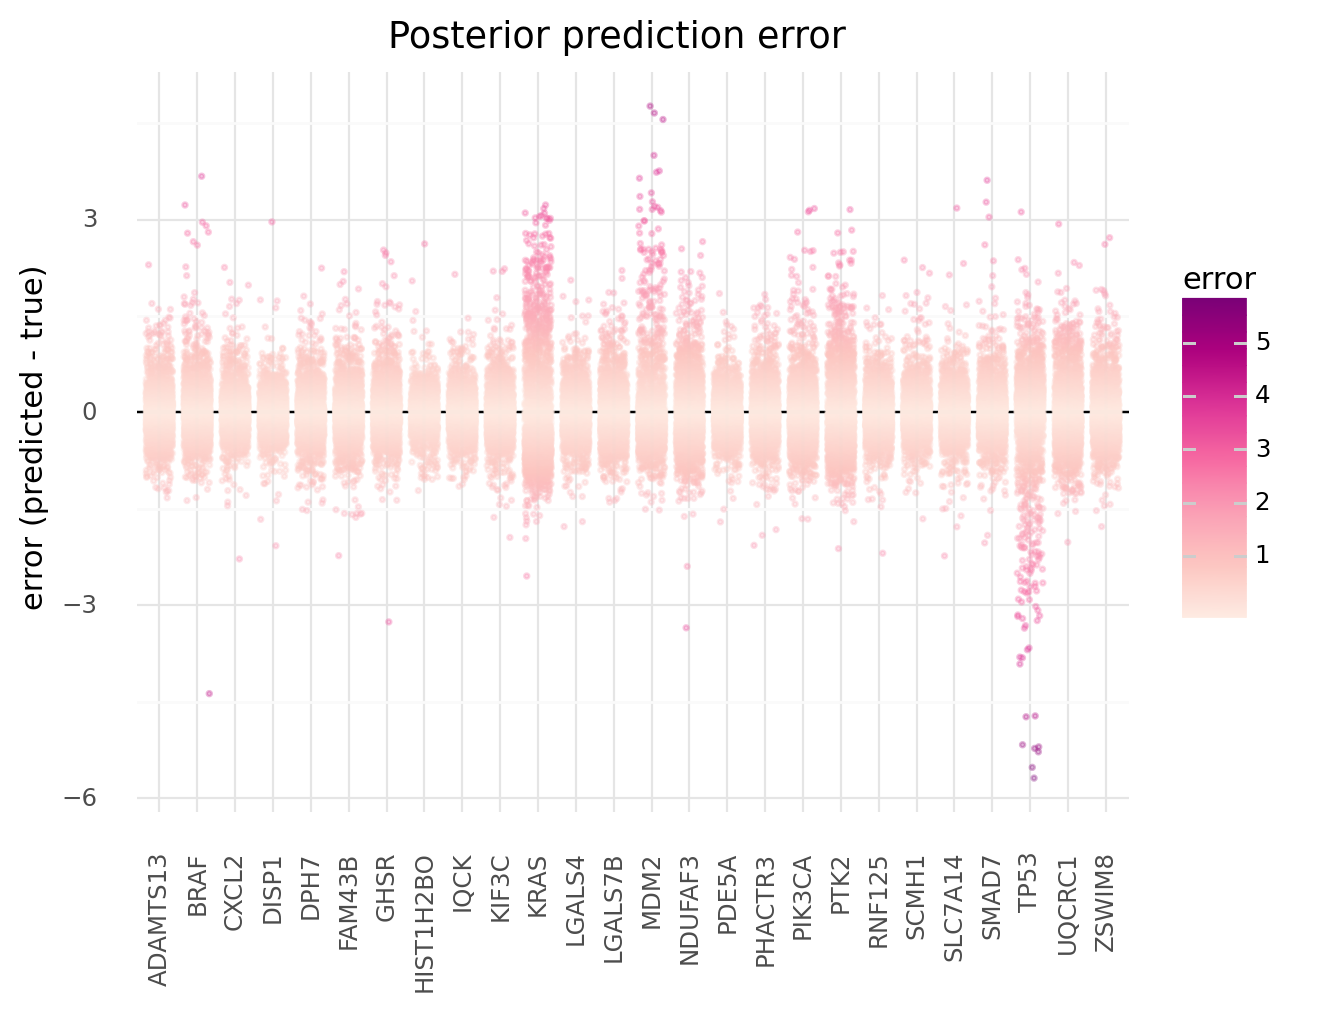

<ggplot: (8779433614439)>

In [34]:
(
    gg.ggplot(ppc_m2_summary, gg.aes(x="hugo_symbol", y="error"))
    + gg.geom_hline(yintercept=0)
    + gg.geom_jitter(
        gg.aes(color="abs(error)"), width=0.35, height=0, size=0.5, alpha=0.3
    )
    + gg.scale_color_distiller(type="seq", palette="RdPu", direction=1)
    + gg.theme(axis_text_x=gg.element_text(rotation=90))
    + gg.labs(
        x=None,
        y="error (predicted - true)",
        title="Posterior prediction error",
        color="error",
    )
)

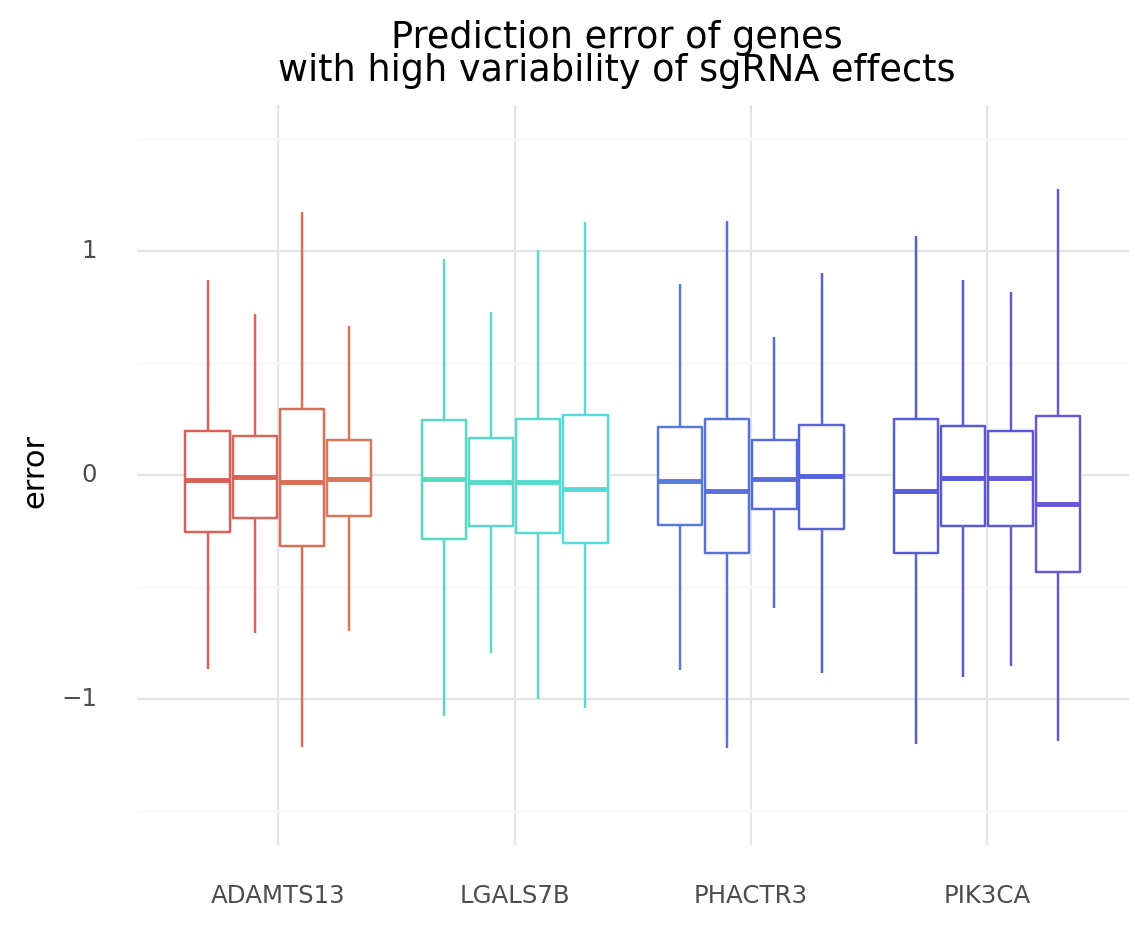

<ggplot: (8779198054873)>

In [35]:
genes_with_sgrna_error = ["ADAMTS13", "LGALS7B", "PHACTR3", "PIK3CA"]
plot_data = ppc_m2_summary[ppc_m2_summary.hugo_symbol.isin(genes_with_sgrna_error)]
(
    gg.ggplot(plot_data, gg.aes(x="hugo_symbol", y="error"))
    + gg.geom_boxplot(
        gg.aes(color="sgrna"), position=gg.position_dodge(width=0.8), outlier_alpha=0
    )
    + gg.scale_color_discrete(guide=None)
    + gg.scale_y_continuous(limits=(-1.5, 1.5))
    + gg.labs(
        x=None,
        y="error",
        title="Prediction error of genes\nwith high variability of sgRNA effects",
    )
)

In [36]:
genes_with_large_error = ["KRAS", "MDM2", "PTK2", "TP53"]

for col in ["n_muts", "any_deleterious", "kras_mutation"]:
    ppc_m2_summary[col] = data[col].values

ppc2_m2_summary_mutations = ppc_m2_summary[
    ppc_m2_summary.hugo_symbol.isin(genes_with_large_error)
].reset_index()
ppc2_m2_summary_mutations["is_mutated"] = ppc2_m2_summary_mutations["n_muts"].values > 0
ppc2_m2_summary_mutations["sgrna_idx"] = get_indices(ppc2_m2_summary_mutations, "sgrna")
ppc2_m2_summary_mutations.head(5)

index  hdi_5.5%  hdi_94.5%      mean  real_value     error hugo_symbol  \
0  22737 -1.695662  -0.131957 -0.945404   -1.668700  0.723296        KRAS   
1  22738 -1.660035  -0.183134 -0.947254   -1.169348  0.222095        KRAS   
2  22739 -1.750201  -0.250295 -0.936529   -1.581876  0.645347        KRAS   
3  22740 -1.655604  -0.152447 -0.928151   -1.485641  0.557490        KRAS   
4  22741 -1.630906  -0.103246 -0.928149   -1.382126  0.453977        KRAS   

                  sgrna   depmap_id  n_muts  any_deleterious kras_mutation  \
0  AATTACTACTTGCTTCCTGT  ACH-000007       1            False          G12D   
1  AATTACTACTTGCTTCCTGT  ACH-000007       1            False          G12D   
2  AATTACTACTTGCTTCCTGT  ACH-000009       0            False            WT   
3  AATTACTACTTGCTTCCTGT  ACH-000009       0            False            WT   
4  AATTACTACTTGCTTCCTGT  ACH-000009       0            False            WT   

   is_mutated  sgrna_idx  
0        True         39  
1        True         39  
2       False         39  
3       False         39  
4       False         39

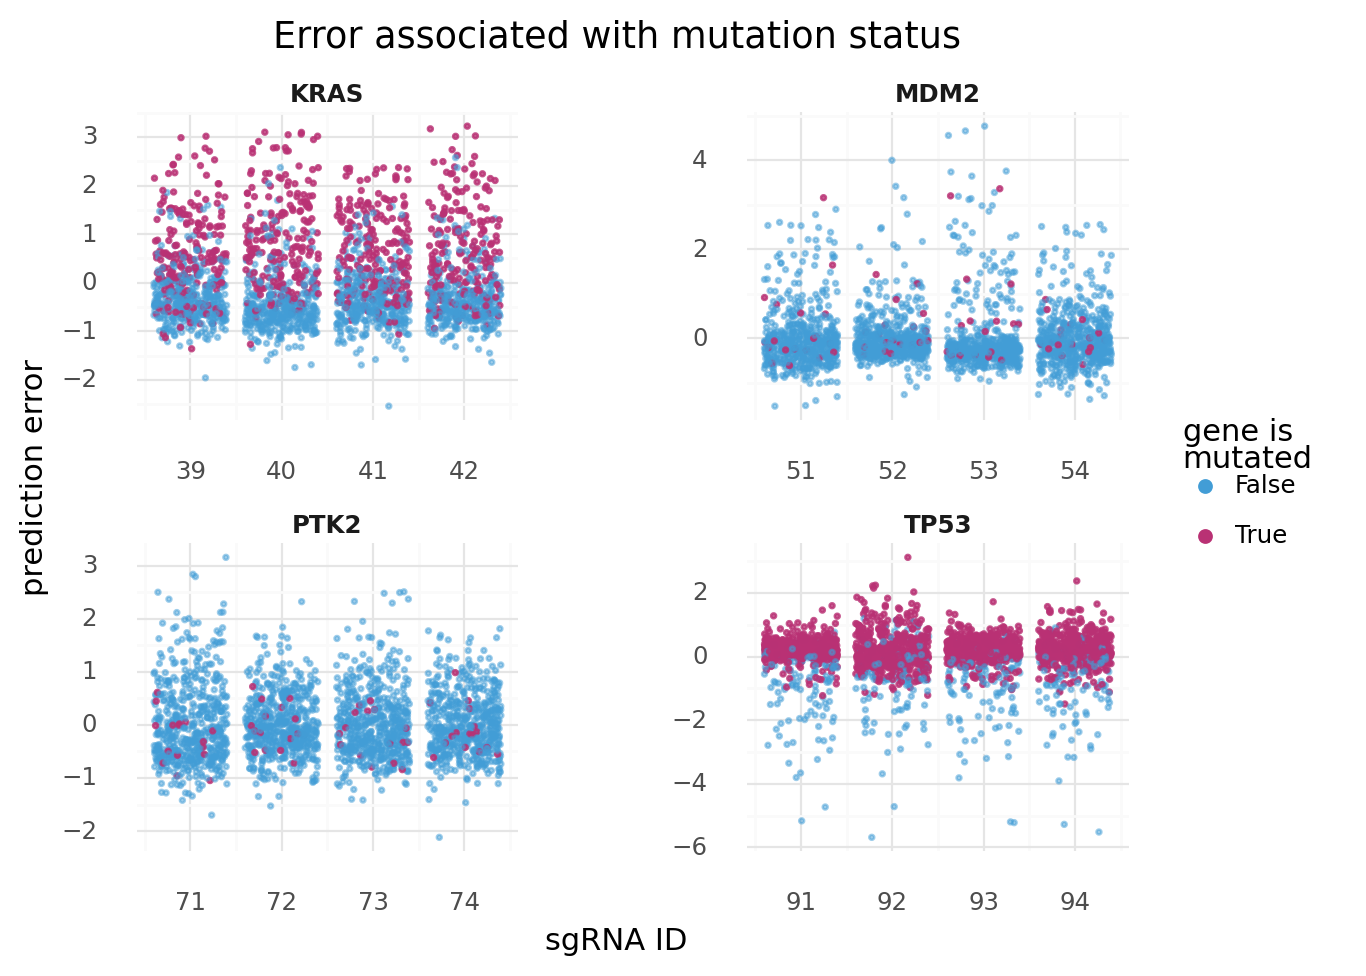

<ggplot: (8779198259194)>

In [37]:
(
    gg.ggplot(ppc2_m2_summary_mutations, gg.aes(x="sgrna_idx", y="error"))
    + gg.facet_wrap("hugo_symbol", scales="free")
    + gg.geom_jitter(gg.aes(color="is_mutated", alpha="is_mutated"), size=0.5)
    + gg.scale_color_manual(values=["#429DD6", "#B93174"])
    + gg.scale_alpha_manual(
        values=[0.5, 0.8], guide=gg.guide_legend(override_aes={"size": 2, "alpha": 1})
    )
    + gg.theme(
        subplots_adjust={"hspace": 0.4, "wspace": 0.6},
        strip_text=gg.element_text(weight="bold"),
    )
    + gg.labs(
        x="sgRNA ID",
        y="prediction error",
        title="Error associated with mutation status",
        color="gene is\nmutated",
        alpha="gene is\nmutated",
    )
)

---

### Model 3. Add cell line varying intercept to Model 2

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_s + \beta_c\\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_{\alpha_s}) \\
\qquad \mu_{\alpha_s} = g_s \\
\qquad \quad g_s \sim \mathcal{N}(\mu_g, \sigma_g) \\
\qquad \qquad \mu_g \sim \mathcal{N}(0, 5) \quad \sigma_g \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_c \sim \mathcal{N}(\mu_{\beta_c}, \sigma_{\beta_c}) \\
\qquad \mu_{\beta_c} \sim \mathcal{N}(0, 5) \quad \sigma_{\beta_c} \sim \text{Exp}(1) \\
\sigma \sim \text{HalfNormal}(5)
$


In [38]:
cell_line_idx = get_indices(data, "depmap_id")
num_cell_lines = data.depmap_id.nunique()
print(f"{num_cell_lines} cell lines")

258 cell lines


In [39]:
with pm.Model() as m3:
    μ_g = pm.Normal("μ_g", 0, 2)
    σ_g = pm.Exponential("σ_g", 1)

    g_s = pm.Normal("g_s", μ_g, σ_g, shape=num_genes)

    μ_β_c = pm.Normal("μ_β_c", 0, 1)
    σ_β_c = pm.Exponential("σ_β_c", 0.5)
    μ_α_s = pm.Deterministic("μ_α_s", g_s[gene_idx])
    σ_α_s = pm.Exponential("σ_α_s", 1)

    β_c = pm.Normal("β_c", μ_β_c, σ_β_c, shape=num_cell_lines)
    α_s = pm.Normal("α_s", μ_α_s, σ_α_s, shape=num_sgrnas)

    μ = pm.Deterministic("μ", α_s[sgrna_idx] + β_c[cell_line_idx])
    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=data.lfc)

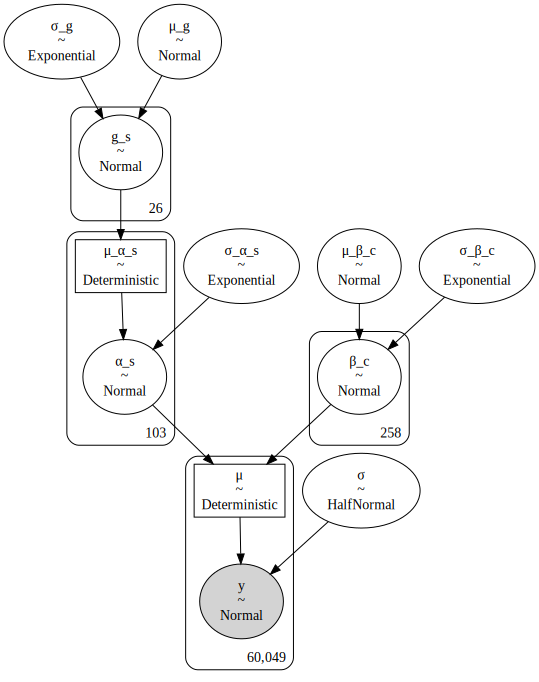

In [40]:
pm.model_to_graphviz(m3)

In [41]:
m3_cache_dir = pymc3_cache_dir / "subset_speclet_m3"

m3_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m3,
    num_mcmc=2000,
    tune=4000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m3_cache_dir,
    force=False,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000, "target_accept": 0.9},
)

Loading cached trace and posterior sample...


In [42]:
m3_az = pmhelp.samples_to_arviz(model=m3, res=m3_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


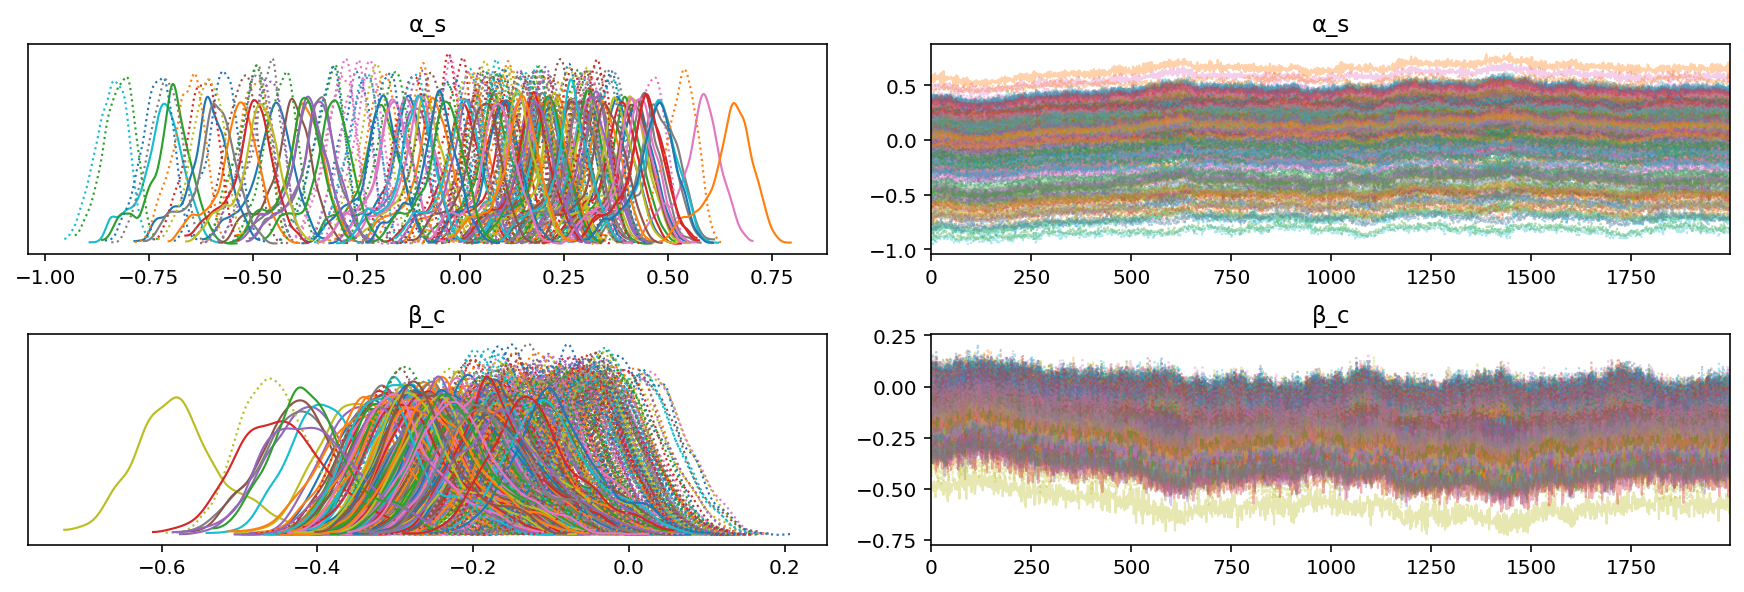

In [43]:
az.plot_trace(m3_az, var_names=["α_s", "β_c"], compact=True)
plt.show()

> This model is currently not sampling properly.
> This is most likely due to non-identifiability with the two varying intercepts.
> I will revist trying to add in cell line in later models.

---

### Model 4. Add mutation covariate to Model 2


---

In [44]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.61 minutes


In [45]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-18

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-236.o2.rc.hms.harvard.edu

Git branch: data-subset-model

arviz     : 0.10.0
pymc3     : 3.9.3
plotnine  : 0.7.1
pandas    : 1.2.0
seaborn   : 0.11.1
numpy     : 1.19.5
re        : 2.2.1
theano    : 1.0.5
matplotlib: 3.3.3

